<h1>Manuscript Code</h1>
<p>The following code was used to analyze and generate data for this manuscript. The output of some cells is deleted to increase readability. While this is not the actual run that was used, the code itself is designed to be reproducible such that equivalent output files can be created from running it. These are equivalent and not identical output files because processes like denoising, taxonomy classification, Inchikey assignment, etc. will produce different results each time they are run. This is mitigated to some degree by the use of random seeds whenever possible, but slight differences in the abundance of individual taxa and metabolites will inevitably arise.</p>

<h3>Environment Setup and Initial Metadata Processing</h3>

In [1]:
%%capture
import dokdo
import qiime2
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import psutil
import re
import rpy2
import math
import requests
import sklearn
import urllib

# This is a custom module with functions related to handling Qiime2 data
import q2Handler

# This little bit of code imports all of the available qiime2 plugins instead of needing to manually import them 1 by 1. 
# If qiime2 is imported without Dokdo, the plugins module will have to be imported
# from qiime2 individually (a la 'from qiime2 import plugins')
for plugin in qiime2.plugins.available_plugins():
    qiime2.plugins.importlib.import_module(plugin)
    
%matplotlib inline
%load_ext rpy2.ipython
sns.set()

# Custom R functions are imported. These are used for a lot of statistical analyses in R later on.
# Many of these functions were modified from code originally made available by Lloyd-Price et al. (2019).
%R source("rFunctions.R")

In [2]:
### Global Variables ###
# Changing baseDir should allow all code in this notebook to be recreated in an arbitrary location,
# provided that the necessary input files (sequences, metadata, metabolites) are in a directory
# called "data" with subdirectories respectively named "16S", "metadata", and "metabolomics".
n_cores = len(psutil.Process().cpu_affinity())
baseDir = pathlib.Path('/work/claytonlab/jhernandez/projects/temp_marm_microbiome')
dataDir = baseDir.joinpath('data')
metaFileDir = dataDir.joinpath('metadata')
seqFileDir = dataDir.joinpath('16S')
metabFileDir = dataDir.joinpath('metabolomics')
analysisDir = baseDir.joinpath('analysis')
artifactDir = analysisDir.joinpath('16S/q2_artifacts')
manifestDir = analysisDir.joinpath('edited_metadata_and_manifests')
figureDir = analysisDir.joinpath('figures')

# Directories are made if they don't exist
for dir in (baseDir, dataDir, metaFileDir, seqFileDir, metabFileDir, analysisDir, artifactDir, manifestDir, figureDir):
    if not dir.exists():
        dir.mkdir(parents=True)

figurePath = figureDir.as_posix()

In [3]:
### Sample Metadata Formatting and Processing ###
fullMeta = pd.read_csv(dataDir.joinpath('metadata/marm_micro_metab_sample_metadata_raw.tsv'), sep='\t')
fullMeta.drop(columns=['Box_#', 'Treatment_Condition', 'Time', 'Experiment_Phase', 'Experiment_Day', 'Notes'], inplace=True)
fullMeta.rename(columns={'Name': 'Individual'}, inplace=True)
fullMeta['Date'] = pd.to_datetime(fullMeta['Date'], format='%m/%d/%y')
fullMeta['DOB'] = pd.to_datetime(fullMeta['DOB'], format='%m/%d/%y')
fullMeta['Age'] = ((fullMeta['Date'] - fullMeta['DOB']) // pd.Timedelta('365 days'))
fullMeta.to_csv(dataDir.joinpath('metadata/marm_micro_metab_sample_metadata_raw2.tsv'), sep='\t')
fullMeta.drop(columns=['DOB'], inplace=True)

sampleMeta = pd.read_csv(dataDir.joinpath('metadata/metadata.tsv'), sep='\t', skiprows=[1])[['sample-id', 'individual', 'condition', 'date']]
sampleMeta.columns = sampleMeta.columns.str.capitalize()
sampleMeta = sampleMeta.rename(columns={'Sample-id': 'Sample_ID'}).astype(str)
sampleMeta[['Individual', 'Condition']] = sampleMeta[['Individual', 'Condition']].apply(lambda x: x.str.capitalize())
sampleMeta['Date'] = pd.to_datetime(sampleMeta['Date'], format='%m/%d/%y')
sampleMeta.sort_values(by=['Individual', 'Date'], inplace=True)

# A Relative_Day column is created, which measures the time in days relative to the earliest date available for each individual
sampleMeta['Relative_Day'] = sampleMeta.apply((lambda x: (x['Date'] - sampleMeta.loc[sampleMeta['Individual'] == x['Individual']]['Date'].min()).days), axis=1)

# A new column is created that de-identifies marmosets (Names are changed to Marm_01, Marm_02, etc)
uniqueMarms = sampleMeta['Individual'].unique()
anonMarms = dict(zip(uniqueMarms, [str(num).zfill(math.floor(math.log10(uniqueMarms.shape[0])) + 1) for num in np.arange(1, uniqueMarms.shape[0]+1)]))
sampleMeta['Anon_Individual'] = sampleMeta['Individual'].apply(lambda x: 'Marm_{num}'.format(num=anonMarms.get(x)))



print(sampleMeta.shape)
sampleMeta['Sample_Number'] = 'ST ' + sampleMeta['Sample_ID'].astype(str)
# sampleMeta.set_index('Sample Number', inplace=True)
sampleMeta = sampleMeta.merge(fullMeta, on=sampleMeta.columns[sampleMeta.columns.isin(fullMeta.columns)].to_list(), sort=True).set_index('Sample_ID')
sampleMeta.sort_values(by=['Individual', 'Date'], inplace=True)

# A Qiime2-friendly metadata sheet is created and the sampleMeta dataframe is reindexed by Sample_ID
sampleMeta.to_csv(manifestDir.joinpath('qiime2_formatted_16s_metadata.tsv'), index=True, index_label='sample-id', sep='\t')

(40, 6)


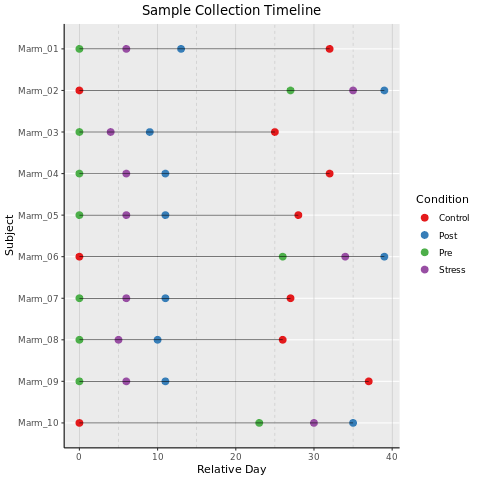

In [4]:
%%capture --no-stdout --no-display
%%R -i sampleMeta,figurePath
library('ggplot2')
library('forcats')

# A plot with collected samples and their time points is created
# Useful for creating themes:
# https://ggplot2.tidyverse.org/reference/theme.html
samplePlot <- ggplot(data=sampleMeta, aes(x=Relative_Day, y=fct_rev(Anon_Individual))) + 
    geom_point(aes(color=Condition), size=3) + geom_line(size=0.25) + 
    scale_color_brewer(palette='Set1') +
    theme(axis.line = element_line(color='black'),
    plot.background = element_rect(fill='white'),
    panel.grid.major.x = element_line(color = 'gray', size = 0.25),
    panel.grid.minor.x = element_line(color = 'gray', size = 0.25, linetype=2),
    panel.border = element_blank(),
    plot.title = element_text(hjust = 0.5),
    legend.key = element_blank()) +
    ylab('Subject') + xlab('Relative Day') + ggtitle('Sample Collection Timeline')
    
plot(samplePlot)
ggsave('sampleCollectionTimeline.pdf', plot=samplePlot, device='pdf', path=figurePath, width=5, height=5, units='in')

<h3>16S Pre-Processing with Qiime2</h3>
<p>Raw 16S reads are pre-processed with the Qiime2 python API. The only output that cannot be fully reproduced from this notebook is the taxonomy classifier cell in this section. That code will work however if it is called from a python script running in a HPC environment.</p>

In [ ]:
### Manifest Generation and Metadata Importing to Qiime2 ###
q2Handler.manifestGen(metadataFile=manifestDir.joinpath('qiime2_formatted_16s_metadata.tsv'), dataDir=seqFileDir, manifestDir=manifestDir, manifestStyle='python')
sample_metadata_md = qiime2.Metadata.load(manifestDir.joinpath('qiime2_formatted_16s_metadata.tsv'), column_types={col: 'categorical' for col in sampleMeta.columns})
manifestFile = manifestDir.joinpath('qiime2_formatted_16s_metadata_python_manifest')

### Sequence Importing ###
paired_end_seqs = qiime2.Artifact.import_data('SampleData[PairedEndSequencesWithQuality]', manifestFile, view_type='PairedEndFastqManifestPhred33')

demux_viz, = qiime2.plugins.demux.actions.summarize(
   data=paired_end_seqs,
)

In [ ]:
# Adapters are trimmed and a visualization of the trimmed sequences is created
trimmed_seqs = qiime2.plugins.cutadapt.methods.trim_paired(
    demultiplexed_sequences=paired_end_seqs,
    cores=n_cores,
    front_f=["GTGCCAGCMGCCGCGGTAA"],
    front_r=["GGACTACHVGGGTWTCTAAT"],
    match_adapter_wildcards=True,
).trimmed_sequences

trimmed_demux_viz, = qiime2.plugins.demux.actions.summarize(
   data=trimmed_seqs,
)

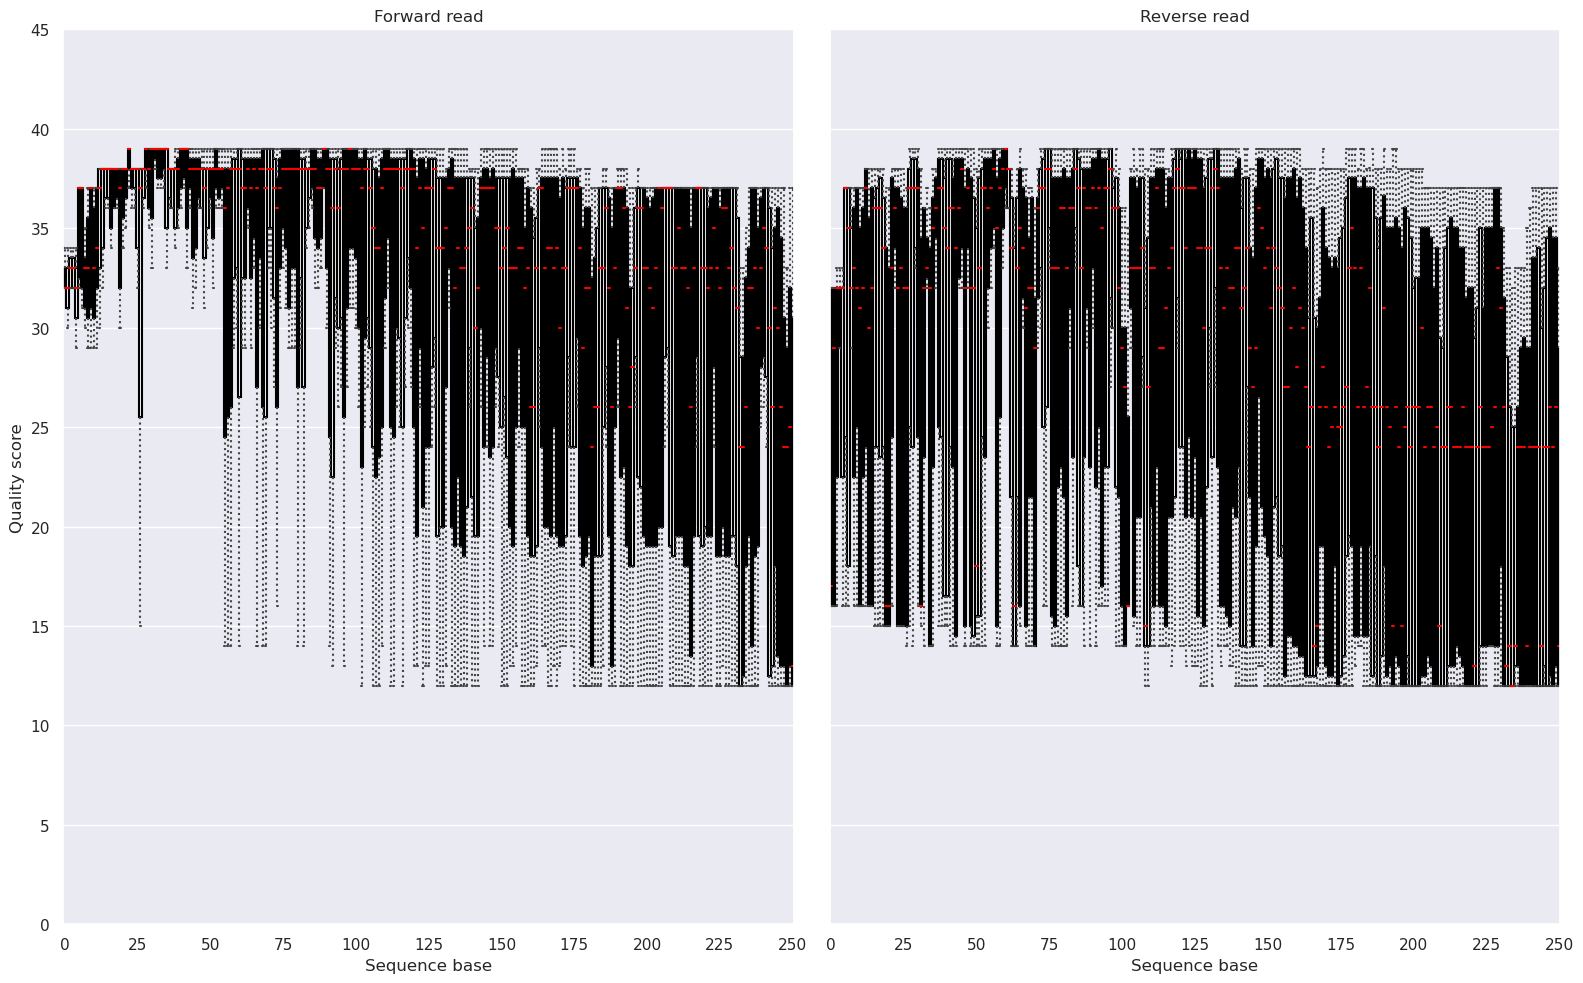

In [7]:
# Read quality visualization
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 10))
qzv_file = demux_viz
dokdo.read_quality_plot(qzv_file, strand='forward', ax=ax1)
dokdo.read_quality_plot(qzv_file, strand='reverse', ax=ax2)
ax1.set_title('Forward read')
ax2.set_title('Reverse read')
ax2.set_ylabel('')
ax2.set_yticklabels([])
ax2.autoscale(enable=True, axis='x', tight=False)
plt.tight_layout()

In [ ]:
### Denoising ###
# # If this gives a confusing error with a -9 exit code 
# # (meaning the process was stopped by the computer), it could be a memory issue.
# # Try increasing the RAM available to the cluster. 10 GB is a good place to start.
# # It seems like this (and maybe other) plugin(s) can't automatically detect the 
# # number of available cores, so that will have to be set automatically
table, rep_seqs, stats = qiime2.plugins.dada2.actions.denoise_paired(
    demultiplexed_seqs=trimmed_seqs,
    trim_left_f=5,
    trim_left_r=5,
    trunc_len_f=242,
    trunc_len_r=155,
    n_threads=n_cores,
)

# Denoising stats are summarized and saved below, along with
# FeatureTable[Frequency] (feature table) and FeatureData[Sequence] (representative sequences) artifacts.
stats_dada2_md_md = stats.view(qiime2.Metadata)

stats_viz, = qiime2.plugins.metadata.actions.tabulate(
    input=stats_dada2_md_md,
)
table_viz, = qiime2.plugins.feature_table.actions.summarize(
    table=table,
    sample_metadata=sample_metadata_md,
)
rep_seqs_viz, = qiime2.plugins.feature_table.actions.tabulate_seqs(
    data=rep_seqs,
)

In [9]:
### Denoising Stats ###
# This allows Interactive Qiime2 Visualizations (only temporary, hence the "sleepTime" argument)
# for viz in (stats_viz, table_viz, rep_seqs_viz):
#     q2Handler.qzvRender(viz, dimen=(1000, 1200), sleepTime=10)

<p>
    Analysis for the taxonomy section was performed using a python script in a HPC environment, but the code is also included
    here to increase reproducibility. This whole section is challenging to run on a jupyter notebook because all of the
    plugins involved tend to randomly crash. This is because they require a lot of RAM. Though a few tips for reducing RAM
    usage are give below, the safest option is to run the code from this cell in an environment with at least 64 Gb 
    of memory available. If the notebook fails, try running the code with sbatch in a Slurm script instead.
</p>

In [10]:
# ### Taxonomy Analysis ###
# ## Acquiring reference sequences and taxonomy for classifier training ##
# # Reads and taxonomy are downloaded from the silva database
# seqUrl = 'https://data.qiime2.org/2022.2/common/silva-138-99-seqs.qza'
# taxUrl = 'https://data.qiime2.org/2022.2/common/silva-138-99-tax.qza'

# seqFn = artifactDir.joinpath('silva-138-99-seqs.qza')
# taxFn = artifactDir.joinpath('silva-138-99-ref-tax.qza')

# urllib.request.urlretrieve(seqUrl, seqFn)
# urllib.request.urlretrieve(taxUrl, taxFn)
# silva_138_99_seq = qiime2.Artifact.load(seqFn)
# silva_138_99_tax = qiime2.Artifact.load(taxFn)

# ## Reads with the appropriate primers are extracted from the silva reads for classifier training ##
# forwardPrimer = 'GTGCCAGCMGCCGCGGTAA'
# reversePrimer = 'GGACTACHVGGGTWTCTAAT'

# # The min_length and max_length parameters can be used to exclude simulated amplicons that are far 
# # outside of the anticipated length distribution using these primers, but I didn't mess with those
# # here.
# silva_138_99_extracted = qiime2.plugins.feature_classifier.methods.extract_reads(
#     sequences = silva_138_99_seq,
#     f_primer = forwardPrimer,
#     r_primer = reversePrimer,
#     n_jobs = n_cores,
# )

# silva_138_99_ref_seqs = silva_138_99_extracted.reads

# # ## Classifier Training ##
# # Chunk size is 20000 by default. Try reducing that for the program not to crash
# nb_classifier = qiime2.plugins.feature_classifier.methods.fit_classifier_naive_bayes(
#     reference_reads=silva_138_99_ref_seqs,
#     reference_taxonomy=silva_138_99_tax,
# )

# fit_nb_classifier = nb_classifier.classifier

# ## Taxonomy Classification ##
# # For this one, you can't just set the n_jobs to be as high as possible. It has a lot of memory issues.
# # Apparently each job uses 4-8 gigs of ram, so it's easy to use more memory than is actually available.
# # If this happens, the classifier just refuses to continue, but doesn't throw an error, so the script
# # gets stuck in limbo. It's pretty fast with 64 gigs of RAM and 5 cores. It might be possible to use
# # a few more. If used in Jupyter, setting 'pre_dispatch' = '1' (string 1, not int 1) and reducing 'n_jobs' might help
# taxonomy, = qiime2.plugins.feature_classifier.actions.classify_sklearn(
#     classifier=fit_nb_classifier,
#     reads=rep_seqs,
#     n_jobs=(n_cores // 3),

# )

# taxonomy_as_md_md = taxonomy.view(qiime2.Metadata)
# taxonomy_viz, = qiime2.plugins.metadata.actions.tabulate(
#    input=taxonomy_as_md_md,
# )

# taxa_bar_plots_viz, = qiime2.plugins.taxa.actions.barplot(
#    table=table,
#    taxonomy=taxonomy,
#    metadata=sample_metadata_md,
# )

In [11]:
# Taxonomy artifacts
silva_138_99_ref_seqs = qiime2.Artifact.load(artifactDir.joinpath('silva-138-99-extracted-ref-seqs.qza'))
fit_nb_classifier = qiime2.Artifact.load(artifactDir.joinpath('silva-138-99-fit-nb-classifier.qza'))
taxonomy = qiime2.Artifact.load(artifactDir.joinpath('taxonomy.qza'))
taxonomy_viz = qiime2.Visualization.load(artifactDir.joinpath('taxonomy.qzv'))
taxa_bar_plots_viz = qiime2.Visualization.load(artifactDir.joinpath('taxa-bar-plots.qzv'))

In [ ]:
## Filtering of feature table ##
# Features occuring in only one sample, or with a total abundance (across samples) < 10 are removed
cont_freq_filter = qiime2.plugins.feature_table.methods.filter_features(
    table=table,
    min_frequency=10,
    min_samples=2,
)
# Mitochondrial and chloroplast taxa, and taxa without genus-level annotation, are removed
mc_table_filter = qiime2.plugins.taxa.methods.filter_table(
    table=cont_freq_filter.filtered_table,
    taxonomy=taxonomy,
    exclude='mitochondria,chloroplast',
    include='g__'
)

# Samples with < 1000 total reads (1075 and 877 in this case) are removed.
sample_table_filter = qiime2.plugins.feature_table.methods.filter_samples(
    table=mc_table_filter.filtered_table,
    min_frequency=1000,
    filter_empty_features=True,
)

filtered_table = sample_table_filter.filtered_table

## Sequence Table Filtering ##
# The sequence table is filtered according to the filtered feature table
seq_filter = qiime2.plugins.feature_table.methods.filter_seqs(
    data=rep_seqs,
    table=filtered_table,
)

filtered_rep_seqs = seq_filter.filtered_data

## Taxonomy Filtering ##
taxonomy_df = taxonomy.view(pd.DataFrame)
filtered_table_df = filtered_table.view(pd.DataFrame)

filtered_taxonomy = qiime2.Artifact.import_data(
    type='FeatureData[Taxonomy]', 
    view=taxonomy_df[taxonomy_df.index.isin(filtered_table_df.transpose().index)]
)

## Visualization ##
filtered_table_viz, = qiime2.plugins.feature_table.actions.summarize(
    table=filtered_table,
    sample_metadata=sample_metadata_md,
)

filtered_rep_seqs_viz, = qiime2.plugins.feature_table.actions.tabulate_seqs(
    data=filtered_rep_seqs,
)

filtered_taxonomy_as_md_md = filtered_taxonomy.view(qiime2.Metadata)
filtered_taxonomy_viz, = qiime2.plugins.metadata.actions.tabulate(
   input=filtered_taxonomy_as_md_md,
)

filtered_taxa_bar_plots_viz, = qiime2.plugins.taxa.actions.barplot(
   table=filtered_table,
   taxonomy=filtered_taxonomy,
   metadata=sample_metadata_md,
)

In [ ]:
### Phylogenetic Tree Creation ###
action_results = qiime2.plugins.phylogeny.actions.align_to_tree_mafft_fasttree(
    sequences=filtered_rep_seqs,
    n_threads=n_cores,
)
aligned_rep_seqs = action_results.alignment
masked_aligned_rep_seqs = action_results.masked_alignment
unrooted_tree = action_results.tree
rooted_tree = action_results.rooted_tree

### Core Diversity Metrics (Phylogenetic) ###
diversity_action_results = qiime2.plugins.diversity.actions.core_metrics_phylogenetic(
    phylogeny=rooted_tree,
    table=filtered_table,
    sampling_depth=1937,   # This is the lowest read depth excluding the 2 samples that were removed earlier
    metadata=sample_metadata_md,
    n_jobs_or_threads=n_cores,
)

rarefied_table = diversity_action_results.rarefied_table
faith_pd_vector = diversity_action_results.faith_pd_vector
observed_features_vector = diversity_action_results.observed_features_vector
shannon_vector = diversity_action_results.shannon_vector
evenness_vector = diversity_action_results.evenness_vector
unweighted_unifrac_pcoa_results = diversity_action_results.unweighted_unifrac_pcoa_results
weighted_unifrac_pcoa_results = diversity_action_results.weighted_unifrac_pcoa_results
jaccard_pcoa_results = diversity_action_results.jaccard_pcoa_results
bray_curtis_pcoa_results = diversity_action_results.bray_curtis_pcoa_results
bray_curtis_distance = diversity_action_results.bray_curtis_distance_matrix

In [ ]:
### Saving Qiime2 Artifacts ###
# Artifacts can be saved immediately after they are generated. 
# All pre-processing artifacts are included in a single cell for convenience.

# # Seqence trimming artifacts
paired_end_seqs.save(artifactDir.joinpath('paired-end-demux.qza').as_posix())
demux_viz.save(artifactDir.joinpath('paired-end-demux.qzv').as_posix())
trimmed_seqs.save(artifactDir.joinpath('trimmed-paired-end-demux.qza').as_posix())
trimmed_demux_viz.save(artifactDir.joinpath('trimmed-paired-end-demux.qzv').as_posix())

# # Denoising and feature summary artifacts
table.save(artifactDir.joinpath('table.qza').as_posix())
rep_seqs.save(artifactDir.joinpath('rep-seqs.qza').as_posix())
stats.save(artifactDir.joinpath('denoising-stats.qza').as_posix())
stats_viz.save(artifactDir.joinpath('denoising-stats.qzv').as_posix())
table_viz.save(artifactDir.joinpath('table.qzv').as_posix())
rep_seqs_viz.save(artifactDir.joinpath('rep-seqs.qzv').as_posix())

# Taxonomy artifacts
silva_138_99_ref_seqs.save(artifactDir.joinpath('silva-138-99-extracted-ref-seqs.qza').as_posix())
fit_nb_classifier.save(artifactDir.joinpath('silva-138-99-fit-nb-classifier.qza').as_posix())
taxonomy.save(artifactDir.joinpath('taxonomy.qza').as_posix())
taxonomy_viz.save(artifactDir.joinpath('taxonomy.qzv').as_posix())
taxa_bar_plots_viz.save(artifactDir.joinpath('taxa-bar-plots.qzv').as_posix())

# Filtering artifacts
filtered_table.save(artifactDir.joinpath('filtered-table.qza').as_posix())
filtered_rep_seqs.save(artifactDir.joinpath('filtered-rep-seqs.qza').as_posix())
filtered_taxonomy.save(artifactDir.joinpath('filtered-taxonomy.qza').as_posix())
filtered_taxonomy_viz.save(artifactDir.joinpath('filtered-taxonomy.qzv').as_posix())
filtered_rep_seqs_viz.save(artifactDir.joinpath('filtered-rep-seqs.qzv').as_posix())
filtered_table_viz.save(artifactDir.joinpath('filtered-table.qzv').as_posix())
filtered_taxonomy_viz.save(artifactDir.joinpath('filtered-taxa-bar-plots.qzv').as_posix())

# Phylogenetic tree and diversity artifacts
aligned_rep_seqs.save(artifactDir.joinpath('alignment.qza').as_posix())
masked_aligned_rep_seqs.save(artifactDir.joinpath('masked_alignment.qza').as_posix())
unrooted_tree.save(artifactDir.joinpath('tree.qza').as_posix())
rooted_tree.save(artifactDir.joinpath('rooted_tree.qza').as_posix())
rarefied_table.save(artifactDir.joinpath('rarefied-table.qza').as_posix())
faith_pd_vector.save(artifactDir.joinpath('faith_pd_vector.qza').as_posix())
observed_features_vector.save(artifactDir.joinpath('observed_features_vector.qza').as_posix())
shannon_vector.save(artifactDir.joinpath('shannon_vector.qza').as_posix())
evenness_vector.save(artifactDir.joinpath('evenness_vector.qza').as_posix())
unweighted_unifrac_pcoa_results.save(artifactDir.joinpath('unweighted_unifrac_pcoa_results.qza').as_posix())
weighted_unifrac_pcoa_results.save(artifactDir.joinpath('weighted_unifrac_pcoa_results.qza').as_posix())
jaccard_pcoa_results.save(artifactDir.joinpath('jaccard_pcoa_results.qza').as_posix())
bray_curtis_pcoa_results.save(artifactDir.joinpath('bray_curtis_pcoa_results.qza').as_posix())
bray_curtis_distance.save(artifactDir.joinpath('bray_curtis_distance_matrix.qza').as_posix())

In [15]:
### Importing Qiime2 Artifacts ###
# Similarly, artifacts can be imported here instead of re-runinng the entire pipeline. 
# All pre-processing artifacts are included in a single cell for convenience.

# Metadata
sample_metadata_md = qiime2.Metadata.load(manifestDir.joinpath('qiime2_formatted_16s_metadata.tsv'), column_types={col: 'categorical' for col in sampleMeta.columns})

# Seqence trimming artifacts
# paired_end_seqs = qiime2.Artifact.load(artifactDir.joinpath('paired-end-demux.qza'))
# demux_viz = qiime2.Visualization.load(artifactDir.joinpath('paired-end-demux.qzv'))
# trimmed_seqs = qiime2.Artifact.load(artifactDir.joinpath('trimmed-paired-end-demux.qza'))
# trimmed_demux_viz = qiime2.Visualization.load(artifactDir.joinpath('trimmed-paired-end-demux.qzv'))

# Denoising and feature summary artifacts
table = qiime2.Artifact.load(artifactDir.joinpath('table.qza'))
rep_seqs = qiime2.Artifact.load(artifactDir.joinpath('rep-seqs.qza'))
stats = qiime2.Artifact.load(artifactDir.joinpath('denoising-stats.qza'))
stats_viz = qiime2.Visualization.load(artifactDir.joinpath('denoising-stats.qzv'))
table_viz = qiime2.Visualization.load(artifactDir.joinpath('table.qzv'))
rep_seqs_viz = qiime2.Visualization.load(artifactDir.joinpath('rep-seqs.qzv'))

# Taxonomy artifacts
# silva_138_99_ref_seqs = qiime2.Artifact.load(artifactDir.joinpath('silva-138-99-extracted-ref-seqs.qza'))
# fit_nb_classifier = qiime2.Artifact.load(artifactDir.joinpath('silva-138-99-fit-nb-classifier.qza'))
taxonomy = qiime2.Artifact.load(artifactDir.joinpath('taxonomy.qza'))
taxonomy_viz = qiime2.Visualization.load(artifactDir.joinpath('taxonomy.qzv'))
taxa_bar_plots_viz = qiime2.Visualization.load(artifactDir.joinpath('taxa-bar-plots.qzv'))

# Filtering artifacts
filtered_table = qiime2.Artifact.load(artifactDir.joinpath('filtered-table.qza'))
# filtered_rep_seqs = qiime2.Artifact.load(artifactDir.joinpath('filtered-rep-seqs.qza'))
# filtered_taxonomy = qiime2.Artifact.load(artifactDir.joinpath('filtered-taxonomy.qza'))
# filtered_taxonomy_viz = qiime2.Visualization.load(artifactDir.joinpath('filtered-taxonomy.qzv'))
# filtered_rep_seqs_viz = qiime2.Visualization.load(artifactDir.joinpath('filtered-rep-seqs.qzv'))
# filtered_table_viz = qiime2.Visualization.load(artifactDir.joinpath('filtered-table.qzv'))
# filtered_taxonomy_viz = qiime2.Visualization.load(artifactDir.joinpath('filtered-taxa-bar-plots.qzv'))

# Phylogenetic tree and diversity artifacts
aligned_rep_seqs = qiime2.Artifact.load(artifactDir.joinpath('alignment.qza'))
masked_aligned_rep_seqs = qiime2.Artifact.load(artifactDir.joinpath('masked_alignment.qza'))
unrooted_tree = qiime2.Artifact.load(artifactDir.joinpath('tree.qza'))
rooted_tree = qiime2.Artifact.load(artifactDir.joinpath('rooted_tree.qza'))
rarefied_table = qiime2.Artifact.load(artifactDir.joinpath('rarefied-table.qza'))
faith_pd_vector = qiime2.Artifact.load(artifactDir.joinpath('faith_pd_vector.qza'))
observed_features_vector = qiime2.Artifact.load(artifactDir.joinpath('observed_features_vector.qza'))
shannon_vector = qiime2.Artifact.load(artifactDir.joinpath('shannon_vector.qza'))
evenness_vector = qiime2.Artifact.load(artifactDir.joinpath('evenness_vector.qza'))
unweighted_unifrac_pcoa_results = qiime2.Artifact.load(artifactDir.joinpath('unweighted_unifrac_pcoa_results.qza'))
weighted_unifrac_pcoa_results = qiime2.Artifact.load(artifactDir.joinpath('weighted_unifrac_pcoa_results.qza'))
jaccard_pcoa_results = qiime2.Artifact.load(artifactDir.joinpath('jaccard_pcoa_results.qza'))
bray_curtis_pcoa_results = qiime2.Artifact.load(artifactDir.joinpath('bray_curtis_pcoa_results.qza'))
bray_curtis_distance = qiime2.Artifact.load(artifactDir.joinpath('bray_curtis_distance_matrix.qza'))

<h3>Metabolomics processing and filtering</h3>
<p>Metabolomics data are read, cross-checked to the PubChem database, filtered, and scaled.</p>

In [16]:
### Metabolomics ###
# Dictionary mapping the column names of the targeted datasets to inchikey
metabColNameToInchikey = { 'αMA (ng/g)': 'DKPMWHFRUGMUKF-GDYCBZMLSA-N', 'βMA (ng/g)': 'DKPMWHFRUGMUKF-CRKPLTDNSA-N',
    'βMA ': 'DKPMWHFRUGMUKF-CRKPLTDNSA-N', 'ΩMA': 'DKPMWHFRUGMUKF-NTPBNISXSA-N', 'ΩMA ': 'DKPMWHFRUGMUKF-NTPBNISXSA-N',
    'CA (ng/g)': 'BHQCQFFYRZLCQQ-OELDTZBJSA-N', 'HCA (ng/g)': 'DKPMWHFRUGMUKF-KWXDGCAGSA-N', 'LCA (µg/g)': 'SMEROWZSTRWXGI-HVATVPOCSA-N',
    'CDCA (µg/g)': 'RUDATBOHQWOJDD-BSWAIDMHSA-N', 'DCA (µg/g)': 'KXGVEGMKQFWNSR-LLQZFEROSA-N', 'GCA (ng/g)': 'RFDAIACWWDREDC-FRVQLJSFSA-N',
    'GCDCA (ng/g)': 'GHCZAUBVMUEKKP-GYPHWSFCSA-N', 'GDCA (ng/g)': 'WVULKSPCQVQLCU-BUXLTGKBSA-N', 'GLCA (ng/g)': 'XBSQTYHEGZTYJE-OETIFKLTSA-N',
    'TCA (ng/g)': 'WBWWGRHZICKQGZ-HZAMXZRMSA-N', 'TCDCA (ng/g)': 'BHTRKEVKTKCXOH-BJLOMENOSA-N', 'TLCA (ng/g)': 'QBYUNVOYXHFVKC-GBURMNQMSA-N',
    'TDCA (ng/g)': 'AWDRATDZQPNJFN-VAYUFCLWSA-N', 'HyPro': 'PMMYEEVYMWASQN-DMTCNVIQSA-N', 'His': 'HNDVDQJCIGZPNO-YFKPBYRVSA-N',
    'Asn': 'DCXYFEDJOCDNAF-REOHCLBHSA-N', 'Tau': 'XOAAWQZATWQOTB-UHFFFAOYSA-N', 'Ser': 'MTCFGRXMJLQNBG-REOHCLBHSA-N',
    'Gln': 'ZDXPYRJPNDTMRX-VKHMYHEASA-N', 'Arg': 'ODKSFYDXXFIFQN-BYPYZUCNSA-N', 'Gly': 'DHMQDGOQFOQNFH-UHFFFAOYSA-N',
    'Asp': 'CKLJMWTZIZZHCS-REOHCLBHSA-N', 'Thr': 'AYFVYJQAPQTCCC-GBXIJSLDSA-N', 'Ala': 'QNAYBMKLOCPYGJ-REOHCLBHSA-N', 
    'GABA': 'BTCSSZJGUNDROE-UHFFFAOYSA-N', 'Pro': 'ONIBWKKTOPOVIA-BYPYZUCNSA-N', 'Orn': 'AHLPHDHHMVZTML-BYPYZUCNSA-N',
    'Cys': 'XUJNEKJLAYXESH-REOHCLBHSA-N', 'Cys2': 'LEVWYRKDKASIDU-IMJSIDKUSA-N', 'Lys': 'KDXKERNSBIXSRK-YFKPBYRVSA-N',
    'Tyr': 'OUYCCCASQSFEME-QMMMGPOBSA-N', 'Met': 'FFEARJCKVFRZRR-BYPYZUCNSA-N', 'Val': 'KZSNJWFQEVHDMF-BYPYZUCNSA-N', 
    'Ile': 'AGPKZVBTJJNPAG-WHFBIAKZSA-N', 'Leu': 'ROHFNLRQFUQHCH-YFKPBYRVSA-N', 'Phe': 'COLNVLDHVKWLRT-QMMMGPOBSA-N',
    'Trp': 'QIVBCDIJIAJPQS-VIFPVBQESA-N', 'Glu': 'WHUUTDBJXJRKMK-VKHMYHEASA-N', 'Acetic acid': 'QTBSBXVTEAMEQO-UHFFFAOYSA-N', 
    'Propionic acid': 'XBDQKXXYIPTUBI-UHFFFAOYSA-N', 'Butyric acid': 'FERIUCNNQQJTOY-UHFFFAOYSA-N',
    'Isovaleric acid': 'GWYFCOCPABKNJV-UHFFFAOYSA-N', 'Valeric acid': 'NQPDZGIKBAWPEJ-UHFFFAOYSA-N'
}

# Dictionaries mapping the inchikey to a tuple with: 
#the PubChem CID (0), common name (1), and molecular formula (2)
metabInchikeyToProperties = {}
# Initial data and metadata are read. The scfa columns measured in "Concentration in µmol/g" are dropped, as they are also measured in mg/g
bileAcids = pd.DataFrame(pd.read_excel(metabFileDir.joinpath('SH_BileAcid_Report_20210222.xlsx'), engine='openpyxl'))
faa = pd.DataFrame(pd.read_excel(metabFileDir.joinpath('SH_FAA_Report_20210114.xlsx'), engine='openpyxl')).iloc[:-2, :27]
scfa = pd.DataFrame(pd.read_excel(metabFileDir.joinpath('SH_SCFAs_Report_20210706_Corrected_20220128.xlsx'), engine='openpyxl', header=1)).iloc[:, :5]

# Duplicate metabolites are removed from the faa dataset according to collaborator's input
faa = faa.drop(columns='Tyr').rename(columns={'Tyr.1': 'Tyr'})

In [17]:
# # PUG REST is used to query the common metabolite names and save the inchikeys.
prolog = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/'
inputs = 'compound/inchikey/'
operation = 'property/inchikey,title,molecularformula,iupacname'
output = '/JSON'
headers = {
    'Content-Type': "application/x-www-form-urlencoded",
}
# Inchikeys from all datasets are combined and queried against the PubChem database
payload = {'inchikey': ','.join(list(metabColNameToInchikey.values()))}

response = requests.request(
    method='POST', 
    url=prolog + inputs + operation + output,
    data=payload,
    headers=headers
)
# Results are written to the metabInchikeyToProperties dict
for record in response.json()['PropertyTable']['Properties']:
    metabInchikeyToProperties.update({record['InChIKey']: [str(record['CID']), record['Title'], record['MolecularFormula'], record['IUPACName']]})

In [ ]:
### Metabolite and Taxonomy Processing ###
## Columns are renamed to allow easier indexing
for df in (bileAcids, faa, scfa):
    df.rename(columns={df.columns[0] : 'Sample_ID'}, inplace=True)
    df.rename(columns=metabColNameToInchikey, inplace=True)
    df['Sample_ID'] = df['Sample_ID'].astype(int)
    

# As the targeted metabolites are quantified in different units, they are converted to a common unit (ug/g)
scfa.iloc[:, 1:] = scfa.iloc[:, 1:].apply(pd.to_numeric, errors='coerce') * 1000
ngCols = bileAcids.loc[:, ~bileAcids.columns.isin(['SMEROWZSTRWXGI-HVATVPOCSA-N','RUDATBOHQWOJDD-BSWAIDMHSA-N','KXGVEGMKQFWNSR-LLQZFEROSA-N'])].copy()
ngCols.iloc[:, 1:] = ngCols.iloc[:, 1:].apply(pd.to_numeric, errors='coerce') / 1000
bileAcids.loc[:, bileAcids.columns.isin(ngCols.columns)] = ngCols

# Metabolites are combined into one dataframe
targetedMetab = scfa.merge(bileAcids, on='Sample_ID').merge(faa, on='Sample_ID').replace(('ND', 0.0), np.NaN)
targetedMetab['Sample_ID'] = targetedMetab['Sample_ID'].astype(str)

# Targeted feature metadata is created
targetedFeatureMeta = {'INCHIKEY': [], 'CID': [], 'Metabolite name': [], 'Formula': [], 'IUPACName': [], 'Method': [], 'Dataset': []}
for tup in ((scfa.columns[1:], 'GC-MS', 'short_chain_fatty_acids'), (bileAcids.columns[1:], 'LC-MS', 'bile_acids'), (faa.columns[1:], 'HPLC', 'amino_acids')):
    for key, value in ((col, metabInchikeyToProperties.get(col)) for col in tup[0]):
        targetedFeatureMeta['INCHIKEY'].append(key)
        targetedFeatureMeta['CID'].append(value[0])
        targetedFeatureMeta['Metabolite name'].append(value[1])
        targetedFeatureMeta['Formula'].append(value[2])
        targetedFeatureMeta['IUPACName'].append(value[3])
        targetedFeatureMeta['Method'].append(tup[1])
        targetedFeatureMeta['Dataset'].append(tup[2])
targetedFeatureMeta = pd.DataFrame(targetedFeatureMeta).T.reset_index()
targetedFeatureMeta.columns = np.concatenate([['Sample_ID'], targetedFeatureMeta.iloc[0, 1:].values])

# The sample_id column is used as a uniting index for all of the dataframes
for df in (targetedMetab, targetedFeatureMeta):
    df.set_index('Sample_ID', inplace=True)

# The samples are reordered in each dataframe to match the order in the sample metadata
targetedMetab = targetedMetab.loc[sampleMeta.index, :]

In [19]:
### Filtering and Feature Scaling ###
# Features with more than 70% missing values are dropped, and remaining missing values are replaced with the median
targetedMetab.drop(columns=targetedMetab.loc[:, (targetedMetab.isna().sum() / targetedMetab.shape[0]) > .70].columns, inplace=True)

# Metabolite datasets are scaled by the median so that each feature has a median of 1.
metabScaled = (targetedMetab.fillna(targetedMetab.median(), axis=0) / targetedMetab.median(axis=0)).dropna(axis=1)
metabUnscaled = targetedMetab.fillna(targetedMetab.median(), axis=0)

# # Metabolite metadata is updated to remove dropped metabolites
targetedFeatureMeta = targetedFeatureMeta[metabScaled.columns]

# # Processed metabolite metadata and abundance are written to output files
targetedFeatureMeta.to_csv(manifestDir.joinpath('processed_metabolite_feature_metadata.tsv'), sep='\t', index=True)
metabUnscaled.to_csv(manifestDir.joinpath('processed_metabolite_abundance.tsv'), sep='\t', index=True)



<h3>Statistical analysis by treatment condition</h3>
<p>A multitude of statistical tests are performed to identify differences in the microbiome and metabolome as a result of treatment condition.</p>

In [ ]:
### Alpha and Beta Significance Testing ###
# As these were tested in Qiime2, relevant tsv files can be obtained by uploading these qzv files to their website
alpha_significance_faith_pd, = qiime2.plugins.diversity.visualizers.alpha_group_significance(
    alpha_diversity=faith_pd_vector,
    metadata=sample_metadata_md,
)

alpha_significance_faith_pd.save(artifactDir.joinpath('alpha-significance-faith-pd.qzv').as_posix()) 
for col in ['Individual', 'Condition', 'Cage', 'Sex', 'Age', 'Treatment_Group']:
    beta_significance_bray_curtis, = qiime2.plugins.diversity.visualizers.beta_group_significance(
        distance_matrix=bray_curtis_distance,
        metadata=sample_metadata_md.get_column(col),
        pairwise=True,
        permutations=9999,
        method='permanova'
    )
    beta_significance_bray_curtis.save(artifactDir.joinpath(f'beta-significance-bray-curtis-{col.lower()}.qzv').as_posix())

In [21]:
# Taxa are collapsed to relative genera abundance
collapsedTaxa = q2Handler.collapseTaxa(tableFile=artifactDir.joinpath('table.qza').as_posix(), taxonomyFile=artifactDir.joinpath('taxonomy.qza').as_posix())
genera_relative_abundance_table, = qiime2.plugins.feature_table.actions.relative_frequency(
    table=collapsedTaxa['level_6']
)

collapsedTaxaFilt = q2Handler.collapseTaxa(tableFile=artifactDir.joinpath('filtered-table.qza').as_posix(), taxonomyFile=artifactDir.joinpath('taxonomy.qza').as_posix())
genera_relative_abundance_table_filt, = qiime2.plugins.feature_table.actions.relative_frequency(
    table=collapsedTaxaFilt['level_6']
)

relativeGenera = genera_relative_abundance_table.view(pd.DataFrame)
filteredRelGenera = genera_relative_abundance_table_filt.view(pd.DataFrame).reset_index(drop=False).rename(columns={'index': 'Sample_ID'})
relativeGenera.index.name = 'Sample_ID'

In [22]:
### Lefse ###
lefseDir = analysisDir.joinpath('16S/lefse')

if not lefseDir.exists():
    lefseDir.mkdir()
    
# A lefse-formatted tsv file is created
sampleMeta[['Condition']].join(filteredRelGenera).T.to_csv(
    analysisDir.joinpath('16S/lefse/relative_genera_lefse_format.tsv'), index=True, na_rep='NaN', sep='\t', index_label='Sample_ID')

sampleMeta.loc[sampleMeta.index.isin(filteredRelGenera['Sample_ID'])][['Condition']].join(filteredRelGenera.set_index('Sample_ID')).T\
    .to_csv(lefseDir.joinpath('relative_genera_lefse_format.tsv'), index=True, na_rep='NaN', sep='\t', index_label='Sample_ID')

In [23]:
%%bash -s "$analysisDir/16S/lefse"
lefseDir=$1
lefse_format_input.py "${lefseDir}/relative_genera_lefse_format.tsv" "${lefseDir}/relative_genera_lefse.in" -c 2 -u 1
lefse_run.py "${lefseDir}/relative_genera_lefse.in" "${lefseDir}/relative_genera_lefse.res"

# This is empty because lefse reports no differentially abundant features
lefse_plot_res.py "${lefseDir}/relative_genera_lefse.res" "${lefseDir}/relative_genera_lefse.png"

Number of significantly discriminative features: 1 ( 1 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 0
No differentially abundant features found in /work/claytonlab/jhernandez/projects/temp_marm_microbiome/analysis/16S/lefse/relative_genera_lefse.res


In [24]:
%%capture --no-stdout --no-display
%%R -i n_cores,figurePath,sampleMeta,metabScaled,targetedFeatureMeta,relativeGenera -o metabRes -w 1000 -h 500

source("rFunctions.R")

sampleMeta$Relative_Day <- as.integer(sampleMeta$Relative_Day)

# Dataframes are concatenated with appropriate metadata
targMetabDat <- convertDF(metabScaled, sampleMeta)
targMetabDat$metaF <- targetedFeatureMeta
relGeneraDat <- convertDF(relativeGenera, sampleMeta)

# Metabolomics data is normalized within method
targMetabDat.nrm <- targMetabDat
imputed <- apply(targMetabDat$x, 2, median)
nfixed <- 0

for (i in seq_along(rownames(targMetabDat.nrm$x))) {
    prf <- targMetabDat.nrm$x[i,]
    nprf <- prf / ave(as.numeric(prf), list(as.character(targMetabDat$metaF["Method",])), FUN=sum)
    outlier <- nprf > 0.5
    
    # Outliers are replaced with the median and normalized again
    while (any(outlier)) {
        nfixed <- nfixed + sum(outlier)
        prf[outlier] <- imputed[outlier]
        nprf <- prf / ave(as.numeric(prf), list(as.character(targMetabDat$metaF["Method",])), FUN=sum)
        outlier <- nprf > 0.5
    }
    targMetabDat.nrm$x[i,] <- nprf
}

# Microbiome data is row-sum normalized
relGeneraDat.nrm <- relGeneraDat
genSums <- rowSums(relGeneraDat.nrm$x)
genSums[genSums == 0] <- 1
relGeneraDat.nrm$x <- relGeneraDat.nrm$x / genSums

# A transformation is applied to the data to reduce the effect of outliers and increase linearity.
# Metabolomics data is log2(x + 1) transformed.
targMetabDat.trans <- targMetabDat
targMetabDat.trans$x <- log2(targMetabDat.trans$x + 1)

# PERMANOVA is run for metabolomics and genera abundance data.
metabPermRes <- runPerm(targMetabDat.nrm, n_cores)
print(metabPermRes)
generaPermRes <- runPerm(relGeneraDat.nrm, n_cores)
print(generaPermRes)

metabRes <- runMixedModel(targMetabDat.trans)

[[1]]
Permutation test for adonis under reduced model
Marginal effects of terms
Plots: df$metaS$Individual, plot permutation: free
Permutation: none
Number of permutations: 9999

adonis2(formula = D ~ Sex + Treatment_Group + Age, data = df$metaS, permutations = bet_perm, method = "bray", by = "margin", parallel = threads)
                Df SumOfSqs      R2      F Pr(>F)
Sex              1  0.03072 0.01647 0.6665 0.9543
Treatment_Group  1  0.04417 0.02369 0.9585 0.7951
Age              4  0.24264 0.13011 1.3163 0.7481
Residual        33  1.52075 0.81549              
Total           39  1.86483 1.00000              

[[2]]
Permutation test for adonis under reduced model
Marginal effects of terms
Blocks:  df$metaS$Treatment_Group 
Plots: df$metaS$Individual, plot permutation: none
Permutation: free
Number of permutations: 9999

adonis2(formula = D ~ Condition + Relative_Day, data = df$metaS, permutations = within_perm, method = "bray", by = "margin", parallel = threads)
             Df 

In [25]:
# Significant metabolites from treatment condition are written to an external file to be compiled later
metabRes = dict(metabRes)
metabSig = metabRes['sig']
metabResid = metabRes['res']

sigMetab = metabSig.loc[(metabSig.iloc[:, -3:] <= 0.05).any(axis=1)]
sigMetab = sigMetab.join(targetedFeatureMeta.T[['INCHIKEY', 'CID', 'Metabolite name']])
sigMetab = pd.concat([sigMetab.iloc[:, -3:], sigMetab.iloc[:, :-3]], axis=1)
if sigMetab.shape[0] > 0:
    display(sigMetab)
else:
    print('No significant metabolites detected')

sigMetabDir = analysisDir.joinpath('metabolomics')
if not sigMetabDir.exists():
    sigMetabDir.mkdir()
    
sigMetab.to_csv(sigMetabDir.joinpath('significant_metabolites_by_condition_raw.tsv'), sep='\t', index=False)

INCHIKEY      CID  \
DKPMWHFRUGMUKF-GDYCBZMLSA-N  DKPMWHFRUGMUKF-GDYCBZMLSA-N  5283852   
BHQCQFFYRZLCQQ-OELDTZBJSA-N  BHQCQFFYRZLCQQ-OELDTZBJSA-N   221493   
RFDAIACWWDREDC-FRVQLJSFSA-N  RFDAIACWWDREDC-FRVQLJSFSA-N    10140   
GHCZAUBVMUEKKP-GYPHWSFCSA-N  GHCZAUBVMUEKKP-GYPHWSFCSA-N    12544   
WVULKSPCQVQLCU-BUXLTGKBSA-N  WVULKSPCQVQLCU-BUXLTGKBSA-N  3035026   
WBWWGRHZICKQGZ-HZAMXZRMSA-N  WBWWGRHZICKQGZ-HZAMXZRMSA-N     6675   
AWDRATDZQPNJFN-VAYUFCLWSA-N  AWDRATDZQPNJFN-VAYUFCLWSA-N  2733768   
XOAAWQZATWQOTB-UHFFFAOYSA-N  XOAAWQZATWQOTB-UHFFFAOYSA-N     1123   
AYFVYJQAPQTCCC-GBXIJSLDSA-N  AYFVYJQAPQTCCC-GBXIJSLDSA-N     6288   
KDXKERNSBIXSRK-YFKPBYRVSA-N  KDXKERNSBIXSRK-YFKPBYRVSA-N     5962   

                                        Metabolite name  pvaluePre  \
DKPMWHFRUGMUKF-GDYCBZMLSA-N       alpha-Muricholic acid   0.003091   
BHQCQFFYRZLCQQ-OELDTZBJSA-N                 Cholic Acid   0.011724   
RFDAIACWWDREDC-FRVQLJSFSA-N            Glycocholic Acid   0.000598   
GHCZAUBVMUEKKP-GYPHWSFCSA-N  Glycochenodeoxycholic Acid   0.001239   
WVULKSPCQVQLCU-BUXLTGKBSA-N       Glycodeoxycholic Acid   0.007678   
WBWWGRHZICKQGZ-HZAMXZRMSA-N            Taurocholic Acid   0.003550   
AWDRATDZQPNJFN-VAYUFCLWSA-N       Taurodeoxycholic Acid   0.007752   
XOAAWQZATWQOTB-UHFFFAOYSA-N                     Taurine   0.005837   
AYFVYJQAPQTCCC-GBXIJSLDSA-N                   Threonine   0.003945   
KDXKERNSBIXSRK-YFKPBYRVSA-N                      Lysine   0.008076   

                             pvalueStress  pvaluePost  log2FCPre  \
DKPMWHFRUGMUKF-GDYCBZMLSA-N      0.009557    0.003905  -0.718026   
BHQCQFFYRZLCQQ-OELDTZBJSA-N      0.012207    0.040085  -1.800111   
RFDAIACWWDREDC-FRVQLJSFSA-N      0.001666    0.001378  -1.118967   
GHCZAUBVMUEKKP-GYPHWSFCSA-N      0.004485    0.007679  -0.795141   
WVULKSPCQVQLCU-BUXLTGKBSA-N      0.000785    0.016134  -0.556565   
WBWWGRHZICKQGZ-HZAMXZRMSA-N      0.017588    0.016781  -2.690550   
AWDRATDZQPNJFN-VAYUFCLWSA-N      0.028253    0.033727  -2.005430   
XOAAWQZATWQOTB-UHFFFAOYSA-N      0.132548    0.203712  -1.967654   
AYFVYJQAPQTCCC-GBXIJSLDSA-N      0.075900    0.174158   0.296367   
KDXKERNSBIXSRK-YFKPBYRVSA-N      0.571170    0.599211   0.446705   

                             log2FCStress  log2FCPost  qvaluePre  \
DKPMWHFRUGMUKF-GDYCBZMLSA-N     -0.619685   -0.698186   0.030769   
BHQCQFFYRZLCQQ-OELDTZBJSA-N     -1.789029   -1.443845   0.045724   
RFDAIACWWDREDC-FRVQLJSFSA-N     -1.005662   -1.026889   0.023326   
GHCZAUBVMUEKKP-GYPHWSFCSA-N     -0.683440   -0.635024   0.024154   
WVULKSPCQVQLCU-BUXLTGKBSA-N     -0.730746   -0.495840   0.034994   
WBWWGRHZICKQGZ-HZAMXZRMSA-N     -2.130208   -2.147440   0.030769   
AWDRATDZQPNJFN-VAYUFCLWSA-N     -1.625303   -1.569692   0.034994   
XOAAWQZATWQOTB-UHFFFAOYSA-N     -1.019457   -0.856194   0.034994   
AYFVYJQAPQTCCC-GBXIJSLDSA-N      0.173556    0.131234   0.030769   
KDXKERNSBIXSRK-YFKPBYRVSA-N      0.089549    0.083064   0.034994   

                             qvalueStress  qvaluePost  
DKPMWHFRUGMUKF-GDYCBZMLSA-N      0.062120    0.050866  
BHQCQFFYRZLCQQ-OELDTZBJSA-N      0.068008    0.142119  
RFDAIACWWDREDC-FRVQLJSFSA-N      0.032481    0.050866  
GHCZAUBVMUEKKP-GYPHWSFCSA-N      0.058307    0.063048  
WVULKSPCQVQLCU-BUXLTGKBSA-N      0.030602    0.081806  
WBWWGRHZICKQGZ-HZAMXZRMSA-N      0.085739    0.081806  
AWDRATDZQPNJFN-VAYUFCLWSA-N      0.122429    0.142119  
XOAAWQZATWQOTB-UHFFFAOYSA-N      0.304080    0.397238  
AYFVYJQAPQTCCC-GBXIJSLDSA-N      0.227699    0.357481  
KDXKERNSBIXSRK-YFKPBYRVSA-N      0.702482    0.743670

<h3>Follow-up statistical analysis and extraction of residuals</h3>
<p>Subsequent statistical testing is performed following removal of stress samples. Microbiome and metabolome data are fitted to a linear model, after which residuals are extracted.</p>

In [26]:
# Samples that were filtered due to low read count are removed from the sample metadata and
# the sample order in relativeGenera is matched to the sample metadata file
relativeGenera = genera_relative_abundance_table_filt.view(pd.DataFrame)
relativeGenera.index.name = 'Sample_ID'

sampleMeta = sampleMeta.loc[sampleMeta.index.isin(relativeGenera.index)]
relativeGenera = relativeGenera.loc[sampleMeta.index]
relativeGenera.to_csv(manifestDir.joinpath('filtered_16s_relative_genera_abundance.tsv'), index=True, na_rep='NaN', sep='\t')

# Filtered samples are also removed from the metabolomics data for subsequent analysis steps
metabScaled = metabScaled.loc[metabScaled.index.isin(sampleMeta.index)]

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


R[write to console]: Loading required package: stats4



[1] "###############"
[1] "###############"


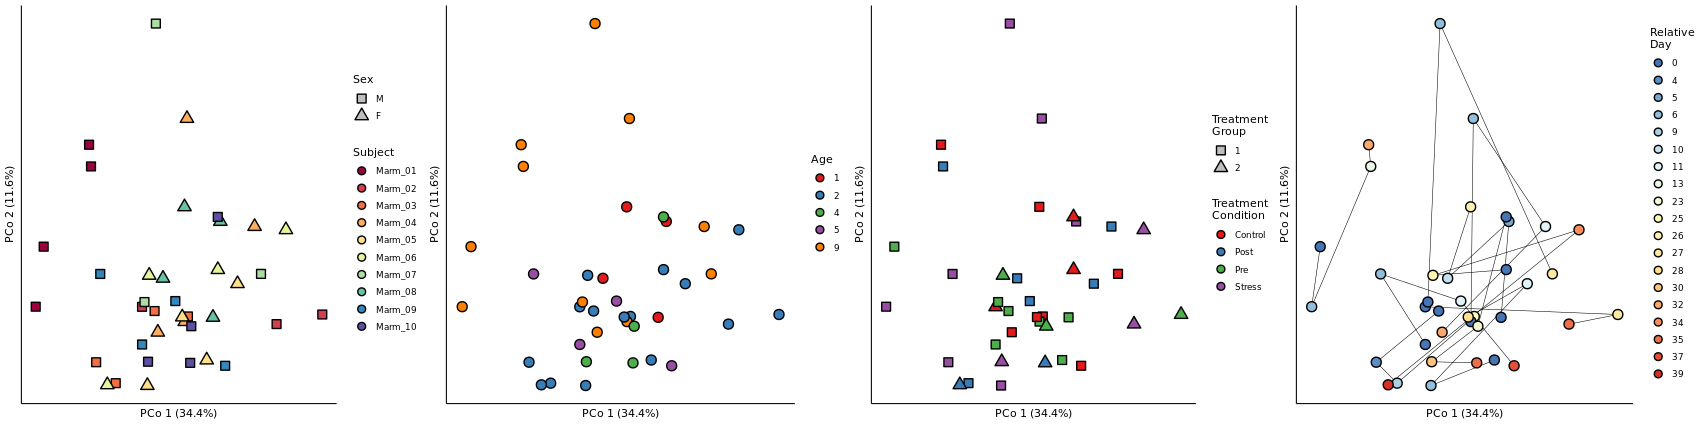

In [27]:
%%R -i figurePath,sampleMeta,metabScaled,relativeGenera,targetedFeatureMeta -o targMetabRes,relGeneraRes -w 1700 -h 425
source("rFunctions.R")
### Ordination ###
sampleMeta$Relative_Day <- as.integer(sampleMeta$Relative_Day)

# Dataframes are concatenated with appropriate metadata
targMetabDat <- convertDF(metabScaled, sampleMeta)
relGeneraDat <- convertDF(relativeGenera, sampleMeta)
targMetabDat$metaF <- targetedFeatureMeta

# Metabolomics data is re-normalized within method (after samples filtered from 16S sequencing were removed)
targMetabDat.nrm <- targMetabDat
imputed <- apply(targMetabDat$x, 2, median)
nfixed <- 0
for (i in seq_along(rownames(targMetabDat.nrm$x))) {
    prf <- targMetabDat.nrm$x[i,]
    nprf <- prf / ave(as.numeric(prf), list(as.character(targMetabDat$metaF["Method",])), FUN=sum)
    outlier <- nprf > 0.5
    
    # Outliers are replaced with the median and normalized again
    while (any(outlier)) {
        nfixed <- nfixed + sum(outlier)
        prf[outlier] <- imputed[outlier]
        nprf <- prf / ave(as.numeric(prf), list(as.character(targMetabDat$metaF["Method",])), FUN=sum)
        outlier <- nprf > 0.5
    }
    targMetabDat.nrm$x[i,] <- nprf
}

# Microbiome data is row-sum normalized
relGeneraDat.nrm <- relGeneraDat
genSums <- rowSums(relGeneraDat.nrm$x)
relGeneraDat.nrm$x <- relGeneraDat.nrm$x / genSums

# Bray-Curtis distance matrix is calculated and a PCoA plot is created
metabPCoA <- PCoA(targMetabDat.nrm)
generaPCoA <- PCoA(relGeneraDat.nrm)
     
metabInd <- ordplot(targMetabDat.nrm, metabPCoA, size_abs=4, outline_size=1, 
                     colour="Anon_Individual", shape="Sex", colour_title="Subject", shape_override=list("M"=22, "F"=24)) + 
                     scale_fill_brewer(palette="Spectral")
metabDay <- ordplot(targMetabDat.nrm, metabPCoA, size_abs=4, outline_size=1, 
                     colour="Relative_Day", connect="Anon_Individual", connectwidth=0.25, colour_title="Relative\nDay")
metabAge <- ordplot(targMetabDat.nrm, metabPCoA, size_abs=4, outline_size=1, 
                     colour="Age") + scale_fill_brewer(palette="Set1")
metabCond <- ordplot(targMetabDat.nrm, metabPCoA, size_abs=4, outline_size=1, 
                     shape="Treatment_Group", shape_override=list("1"=22, "2"=24), shape_title="Treatment\nGroup",
                     colour="Condition", colour_title="Treatment\nCondition")

metabPlot <- ggarrange(metabInd, metabAge, metabCond, metabDay, ncol=4, nrow=1)

plot(metabPlot)
ggsave('metabPCoA.pdf', plot=metabPlot, device='pdf', path=figurePath, width=22, height=5.5, units='in')


generaInd <- ordplot(relGeneraDat.nrm, generaPCoA, size_abs=4, outline_size=1,
                     colour="Anon_Individual", shape="Sex", colour_title="Subject", shape_override=list("M"=22, "F"=24)) + 
                     scale_fill_brewer(palette="Spectral")
generaDay <- ordplot(relGeneraDat.nrm, generaPCoA, size_abs=4, outline_size=1,
                     colour="Relative_Day", connect="Anon_Individual", connectwidth=0.25, colour_title="Relative\nDay")
generaAge <- ordplot(relGeneraDat.nrm, generaPCoA, size_abs=4, outline_size=1,
                     colour="Age") + scale_fill_brewer(palette="Set1")
generaCond <- ordplot(relGeneraDat.nrm, generaPCoA, size_abs=4, outline_size=1,
                      shape="Treatment_Group", shape_override=list("1"=22, "2"=24), shape_title="Treatment\nGroup",
                      colour="Condition", colour_title="Treatment\nCondition")

generaPlot <- ggarrange(generaInd, generaAge, generaCond, generaDay, ncol=4, nrow=1)

plot(generaPlot)
ggsave('generaPCoA.pdf', plot=generaPlot, device='pdf', path=figurePath, width=22, height=5.5, units='in')

# A transformation is applied to the data to reduce the effect of outliers and increase linearity.
# Metabolomics data is log2(x + 1) transformed, and microbiome data is arcsine square-root transformed.
targMetabDat.trans <- targMetabDat
targMetabDat.trans$x <- log2(targMetabDat.trans$x + 1)
relGeneraDat.trans <- relGeneraDat
relGeneraDat.trans$x <- asin(sqrt(relGeneraDat.trans$x))

# The transformed data are fit to a linear model and the residuals are extracted for downstream correlation analysis
targMetabRes <- extractResid(targMetabDat.trans)
relGeneraRes <- extractResid(relGeneraDat.trans)

In [28]:
### Saving Residuals and Creation of Node Properties Table ###

# Residuals are written to a new directory 
resDir = analysisDir.joinpath('fitted_residuals')
if not resDir.exists():
    resDir.mkdir() 

# A directory for node properties is also made
nodeDir = analysisDir.joinpath('node_properties')
if not nodeDir.exists():
    nodeDir.mkdir()

targMetabRes.T.to_csv(resDir.joinpath('targeted_metabolites.tsv'), sep='\t', index=True, index_label='Sample_ID')
relGeneraRes.T.to_csv(resDir.joinpath('relative_genera.tsv'), sep='\t', index=True, index_label='Sample_ID')

# The node properties table is created and saved for use in Cytoscape
nodeKeyToProperties = {}
targetedFeatureMeta.apply(lambda x: nodeKeyToProperties.update({x['INCHIKEY']: [x['Metabolite name'], x['Dataset'], 'metabolite']}))

pat = re.compile('^.*f__([^;]+);g_(.+)$')
[nodeKeyToProperties.update({col: [''.join(pat.match(col).groups(0)), pat.match(col).group(1), 'microbe',]}) for col in relativeGenera.columns]
nodeProperties = pd.DataFrame(nodeKeyToProperties).T.reset_index().rename(columns={'index': 'key', 0: 'common_name', 1: 'parent_group', 2: 'type'})
sigCounts = (sigMetab[['qvaluePre', 'qvalueStress', 'qvaluePost']] < 0.05).sum(axis=1).to_dict()
nodeProperties['diff_expr'] = nodeProperties.apply(lambda row: (sigCounts.get(row['key']) if row['key'] in sigCounts else 0), axis=1)
# display((sigMetab[['qvaluePre', 'qvalueStress', 'qvaluePost']] < 0.05))
# # display(sigMetab[nodeProperties[nodeProperties['diff_expr'] > 0]])
# display(nodeProperties[nodeProperties['diff_expr'] > 0])

nodeProperties['diff_direction'] = nodeProperties.apply(\
    lambda row: ((sigMetab.loc[row['key'], 'log2FCPre'] > 0) if row['diff_expr'] > 0 else '0'), axis=1)
nodeProperties['diff_direction'].replace({True: '+', False: '-'}, inplace=True)
nodeProperties.to_csv(nodeDir.joinpath('node_properties.tsv'), sep='\t', index=False)

# Residual column names are replaced with common names for pretty halla output
targMetabCommonName = targMetabRes.copy()
relGeneraCommonName = relGeneraRes.copy()
targMetabCommonName.columns = [nodeKeyToProperties.get(col)[0] for col in targMetabCommonName.columns]
relGeneraCommonName.columns = [nodeKeyToProperties.get(col)[0] for col in relGeneraCommonName.columns]
targMetabCommonName.T.to_csv(resDir.joinpath('targeted_metabolites_common_name.tsv'), sep='\t', index=True, index_label='Sample_ID')
relGeneraCommonName.T.to_csv(resDir.joinpath('relative_genera_common_name.tsv'), sep='\t', index=True, index_label='Sample_ID')

for dset in targetedFeatureMeta.loc['Dataset'].unique():
    dsetRes = targMetabRes.loc[:, targetedFeatureMeta.loc['Dataset'] == dset]
    dsetRes.T.to_csv(resDir.joinpath(dset + '.tsv'), sep='\t', index=True, index_label='Sample_ID')
    dsetResCommonName = dsetRes.copy()
    dsetResCommonName.columns = [nodeKeyToProperties.get(col)[0] for col in dsetResCommonName.columns]
    dsetResCommonName.T.to_csv(resDir.joinpath(dset + '_common_name.tsv'), sep='\t', index=True, index_label='Sample_ID')

<h3>Residual correlation and network construction</h3>
<p>Within-dataset and between-dataset correlation of extracted residuals is performed respectively with AllA and HAllA</p>

In [29]:
%%bash -s "$resDir" "$analysisDir"
residualDir=$1
outputDir=$2

# Halla ((hierarchical all-against-all association testing) is performed against all feature pairs.
# Alla, the non-hierarchical variant of Halla, is used for within-dataset associations, while Halla is used for between-dataset associations.
if [[ -d "${outputDir}/halla_output" ]]; then
    rm -r "${outputDir}/halla_output"
fi

mkdir -p "${outputDir}/halla_output/"{non_graphical_output,graphical_output}

# Non-graphical halla output has INCHIKEYS/Full microbe taxa for column names and is used for downstream Cytoscape analysis.
# Graphical halla output has common metabolite names and shortened taxa as column names and is used for generation of a hallagram
hallaDir="${outputDir}/halla_output/non_graphical_output"
halla -x "${residualDir}/targeted_metabolites.tsv" -y "${residualDir}/relative_genera.tsv" -m spearman\
    -o "${hallaDir}/metabolite-genera" --seed 777 --permute_iters 10000 --no_hallagram --dont_copy --disable_verbose
halla -x "${residualDir}/targeted_metabolites.tsv" -y "${residualDir}/targeted_metabolites.tsv" -m spearman\
    -o "${hallaDir}/metabolite-metabolite" --seed 777 --permute_iters 10000  --alla --no_hallagram --dont_copy --disable_verbose
halla -x "${residualDir}/relative_genera.tsv" -y "${residualDir}/relative_genera.tsv" -m spearman\
    -o "${hallaDir}/genera-genera" --seed 777 --permute_iters 10000 --alla --no_hallagram --dont_copy --disable_verbose

hallaDir="${outputDir}/halla_output/graphical_output"
halla -x "${residualDir}/targeted_metabolites_common_name.tsv" -y "${residualDir}/relative_genera_common_name.tsv" -m spearman\
    -o "${hallaDir}/metabolite-genera" --seed 777 --permute_iters 10000 --clustermap --disable_verbose --no_hallagram
hallagram -i "${hallaDir}/metabolite-genera"
halla -x "${residualDir}/targeted_metabolites_common_name.tsv" -y "${residualDir}/targeted_metabolites_common_name.tsv" -m spearman\
    -o "${hallaDir}/metabolite-metabolite" --seed 777 --permute_iters 10000 --alla --disable_verbose --no_hallagram
hallagram -i "${hallaDir}/metabolite-metabolite" --suppress_numbers
halla -x "${residualDir}/relative_genera_common_name.tsv" -y "${residualDir}/relative_genera_common_name.tsv" -m spearman\
    -o "${hallaDir}/genera-genera" --seed 777 --permute_iters 10000 --alla --disable_verbose --no_hallagram
hallagram -i "${hallaDir}/genera-genera" --suppress_numbers

100%|██████████| 55/55 [00:00<00:00, 77.19it/s]


In [30]:
### Aggregation of Halla Output ###
hallaOutput = analysisDir.joinpath('halla_output')
pat = re.compile('^.+\/(.+)-(.+)$')
qValCutoff = 0.05

# All associations are aggregated and saved in one file
with open(nodeDir.joinpath('associations.tsv'), 'w') as f:
    f.write('X_features\tY_features\tassociation\tp-values\tq-values\tinteraction_type\n')
    # Each associations directory is iterated through individually
    for d in hallaOutput.joinpath('non_graphical_output').iterdir():
        match = pat.match(str(d))
        # Symmetrical matrices are processed differently than asymmetrical ones
        if match and match.group(1) == match.group(2):
            associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t').pivot(index = 'X_features', columns='Y_features') + 2
            
            # The upper triangle of the associations matrix is taken, while the lower triangle (duplicates) is replaced with 0 and dropped
            pairs = []
            for level in associations.columns.levels[0]:
                triu = pd.DataFrame(np.triu(associations[level]), index=associations[level].index, columns=associations[level].columns)\
                            .replace(0, np.NaN).stack().reset_index()
                triu.rename(columns={0: level}, inplace=True)
                pairs.append(triu)

            # The associations matrix is reconstructed and 2 is subtracted again
            associations = pairs[0].merge(pairs[1], how='outer', on=['X_features', 'Y_features']).merge(pairs[2], how='outer', on=['X_features', 'Y_features'])
            associations.iloc[:, 2:] = associations.iloc[:, 2:] - 2

            # The association is classified as within-dataset or between-dataset, depending on if halla or alla was used
            associations['interaction_type'] = d.name
            # Features that paired with themselves and features with a q-value less than qValueCutoff are removed
            associations = associations.loc[(associations['X_features'] != associations['Y_features']) & (associations['q-values'] < qValCutoff)].reset_index(drop=True)
            associations.to_csv(f, mode='a', sep='\t', index=False, header=False)
        else:
            associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t')
            associations['interaction_type'] = d.name
            associations = associations.loc[(associations['q-values'] < qValCutoff)].reset_index(drop=True)
            associations.to_csv(f, mode='a', sep='\t', index=False, header=False)

<h3>Eigendecomposition, A/B Classification, and Hierarchical Clustering</h3>

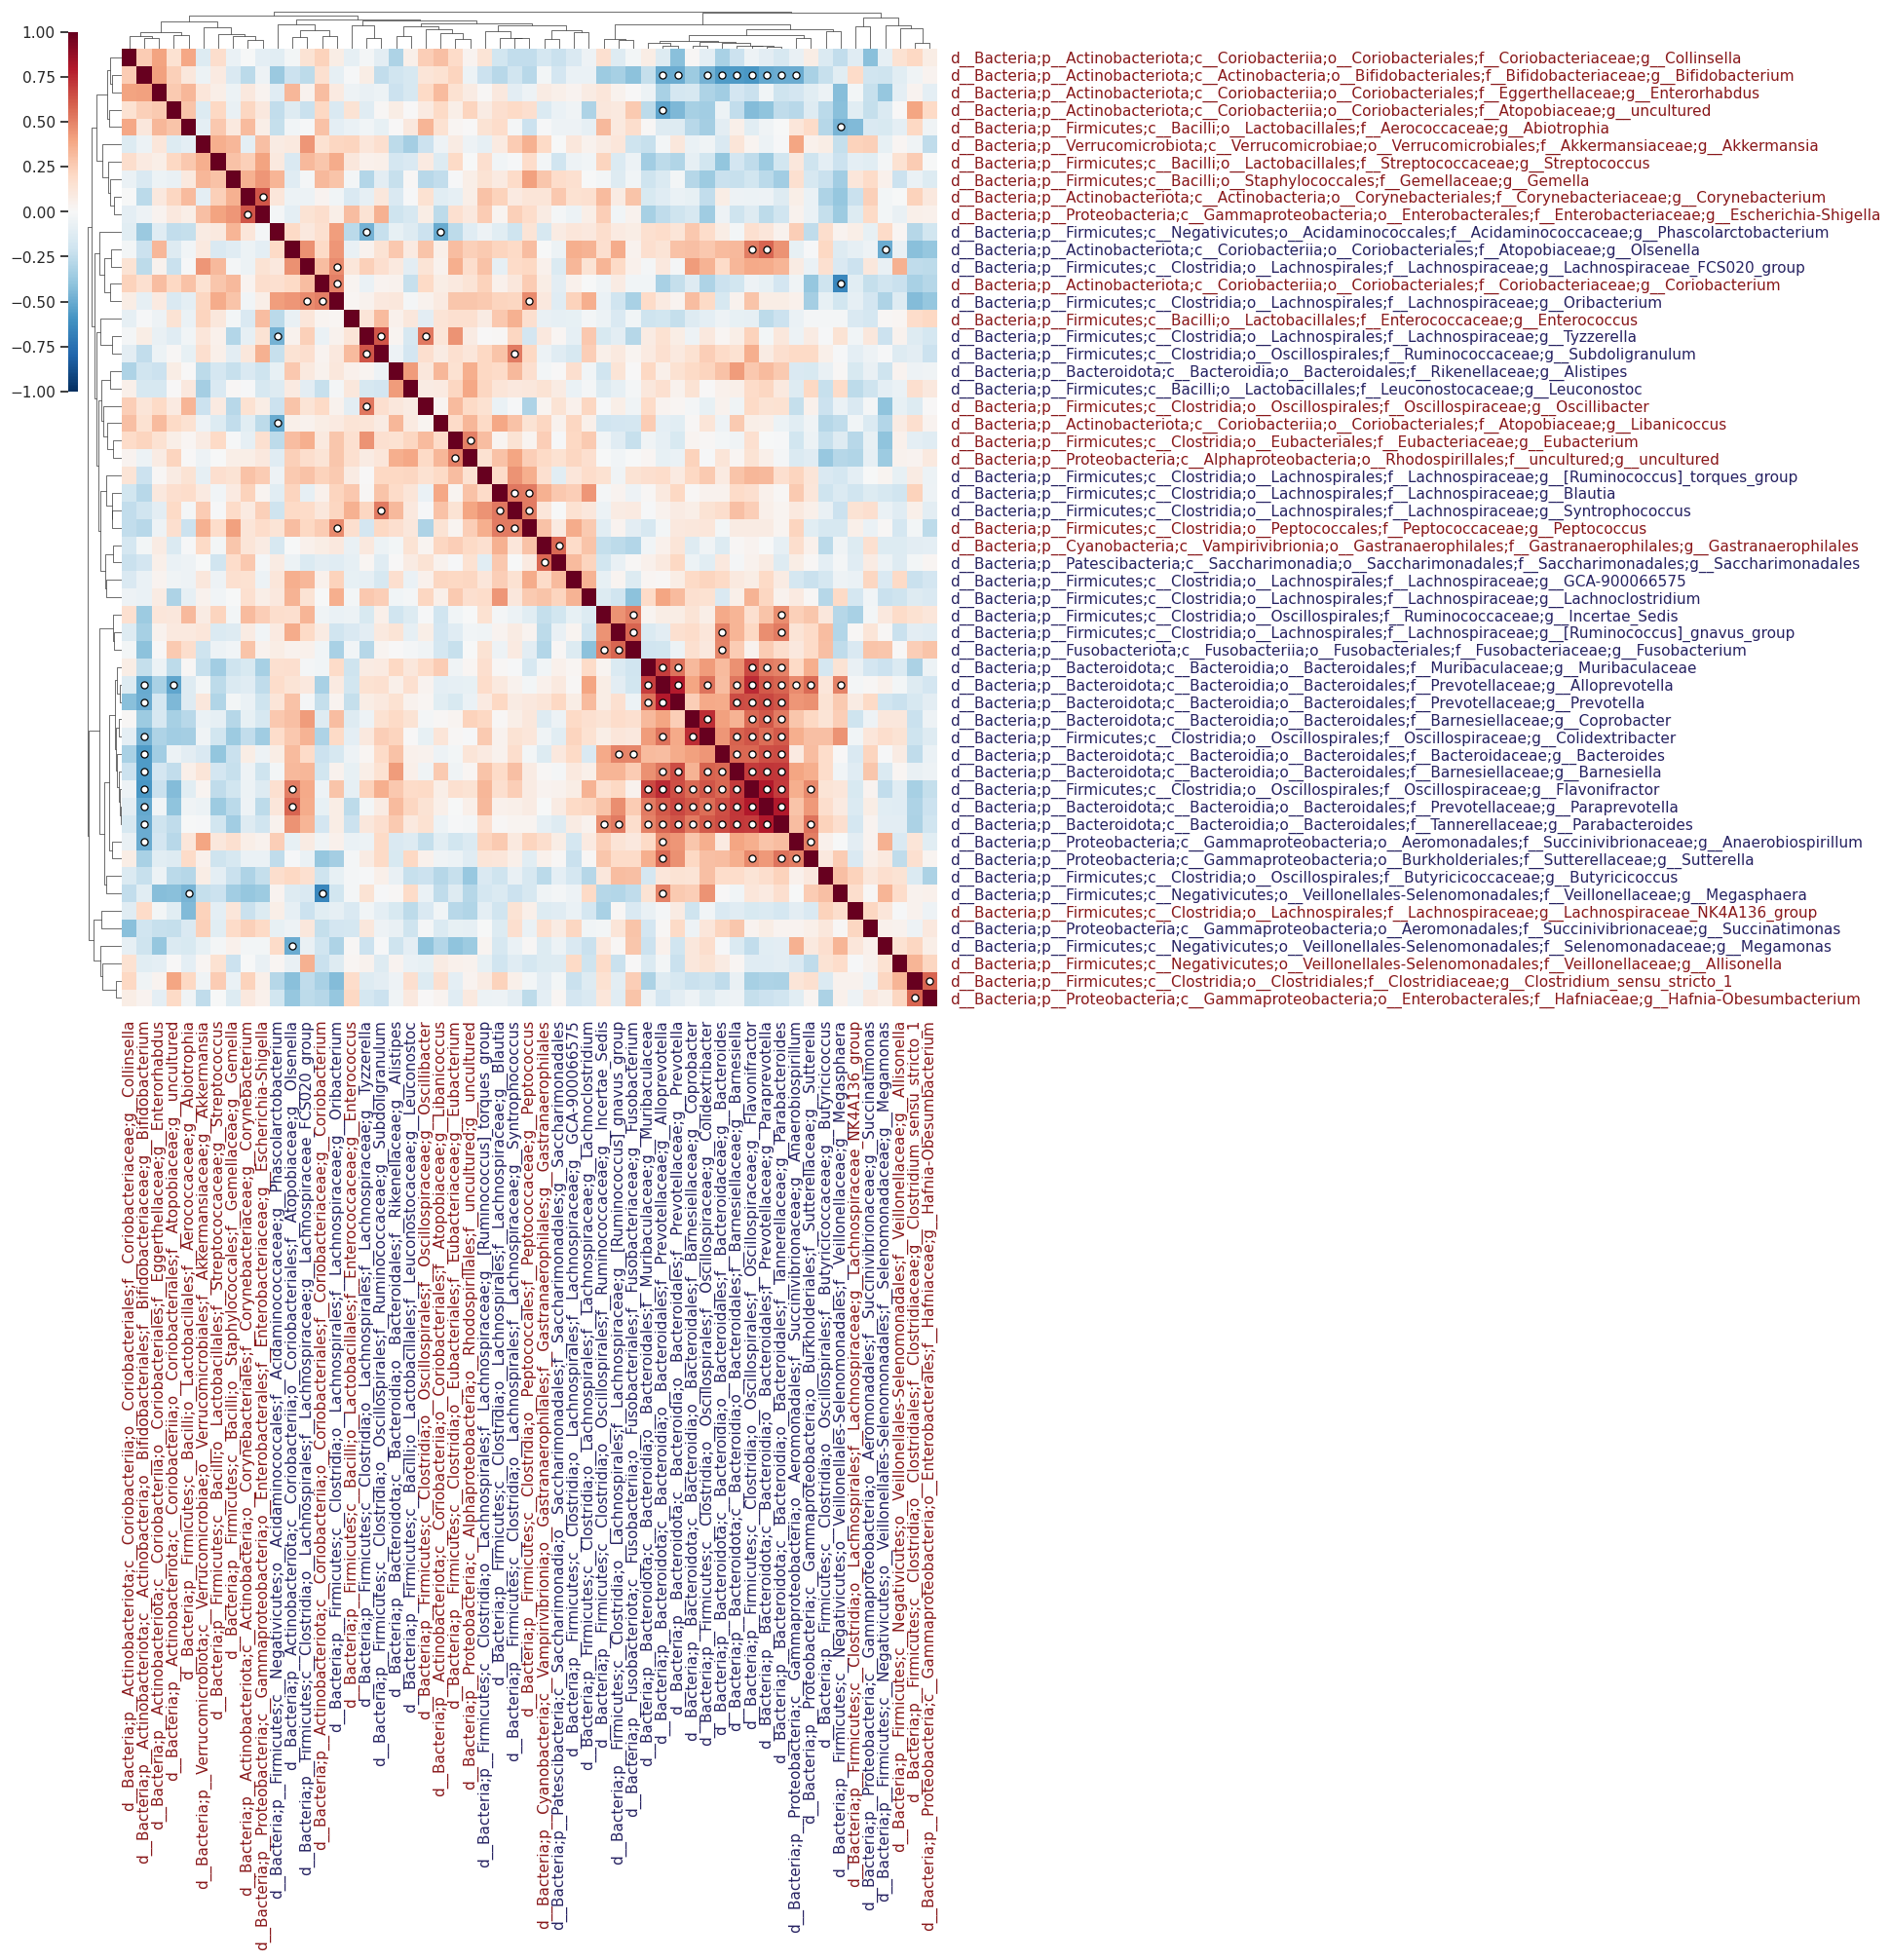

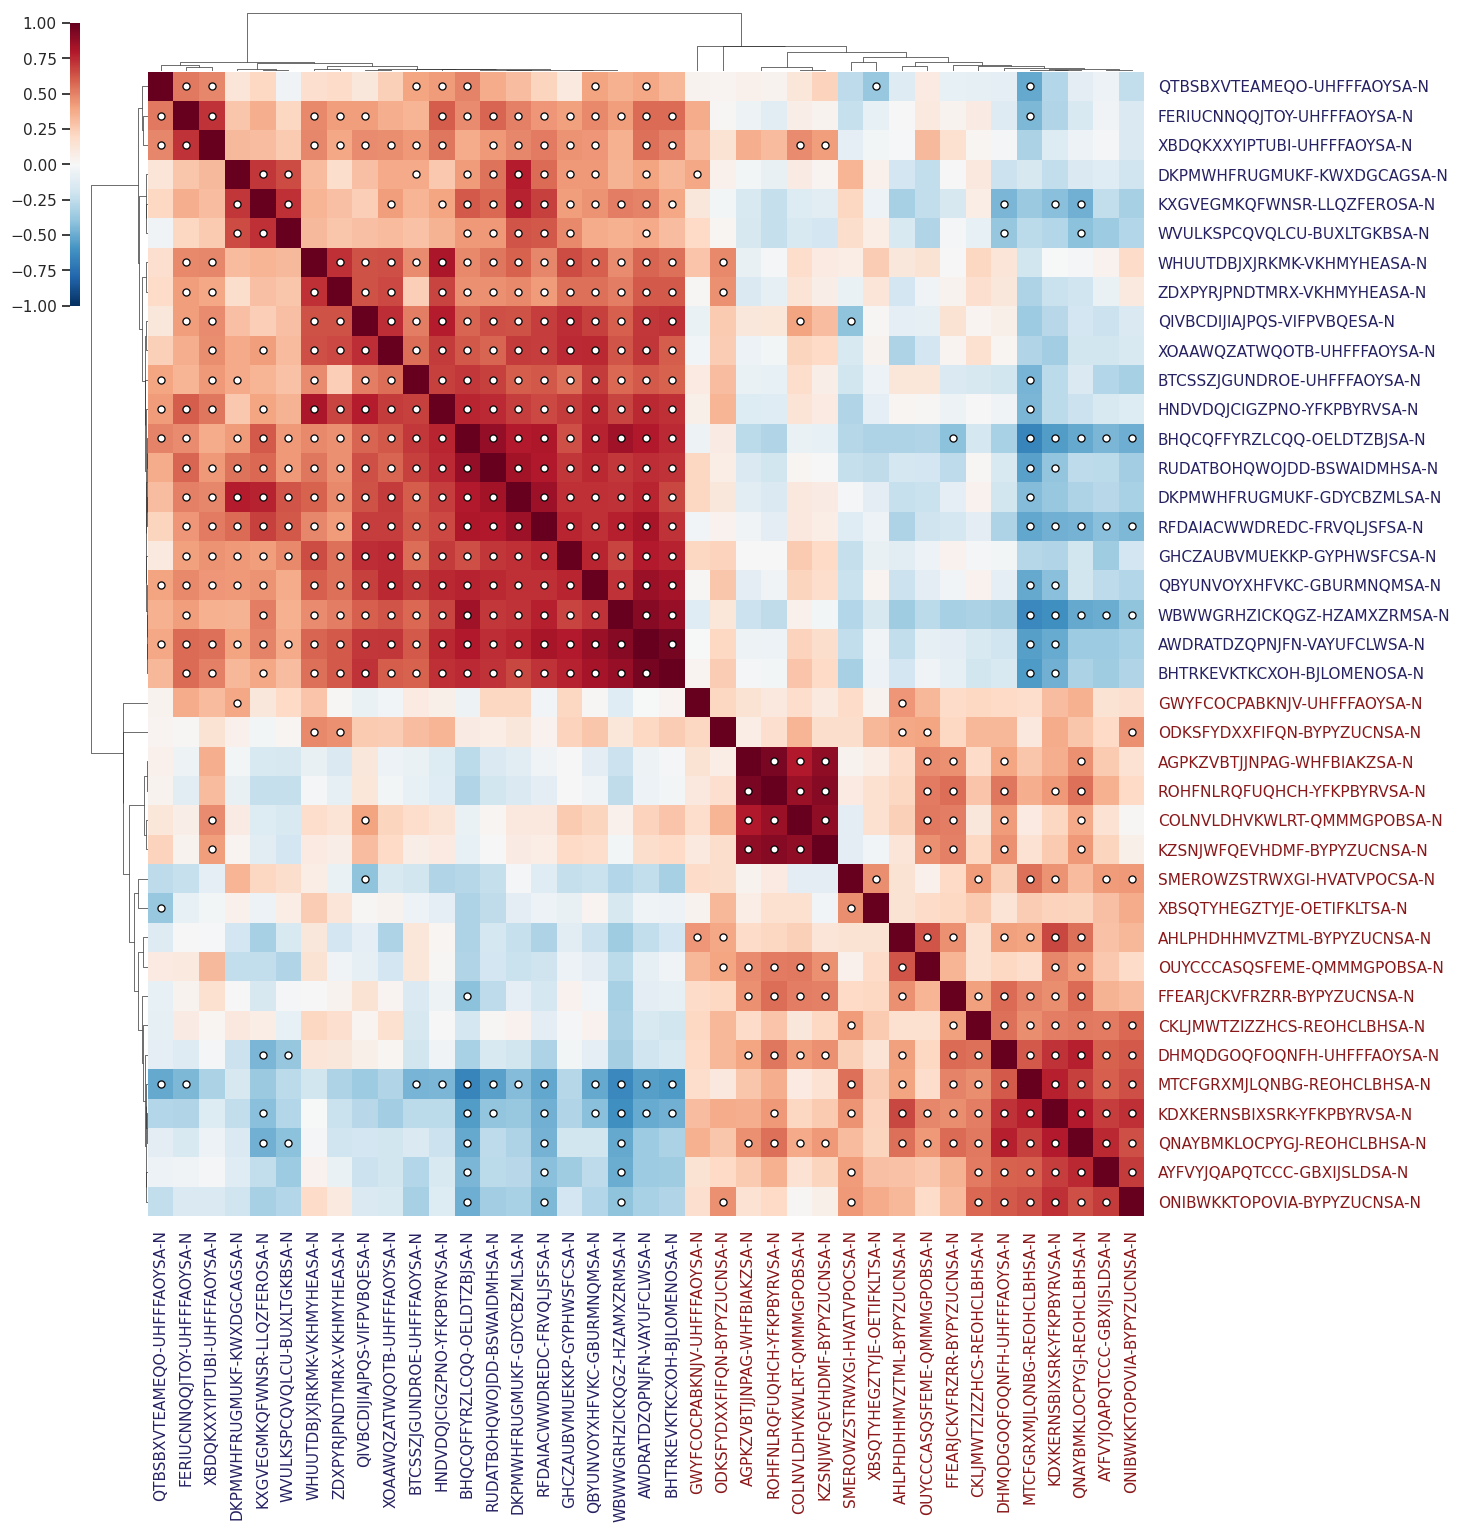

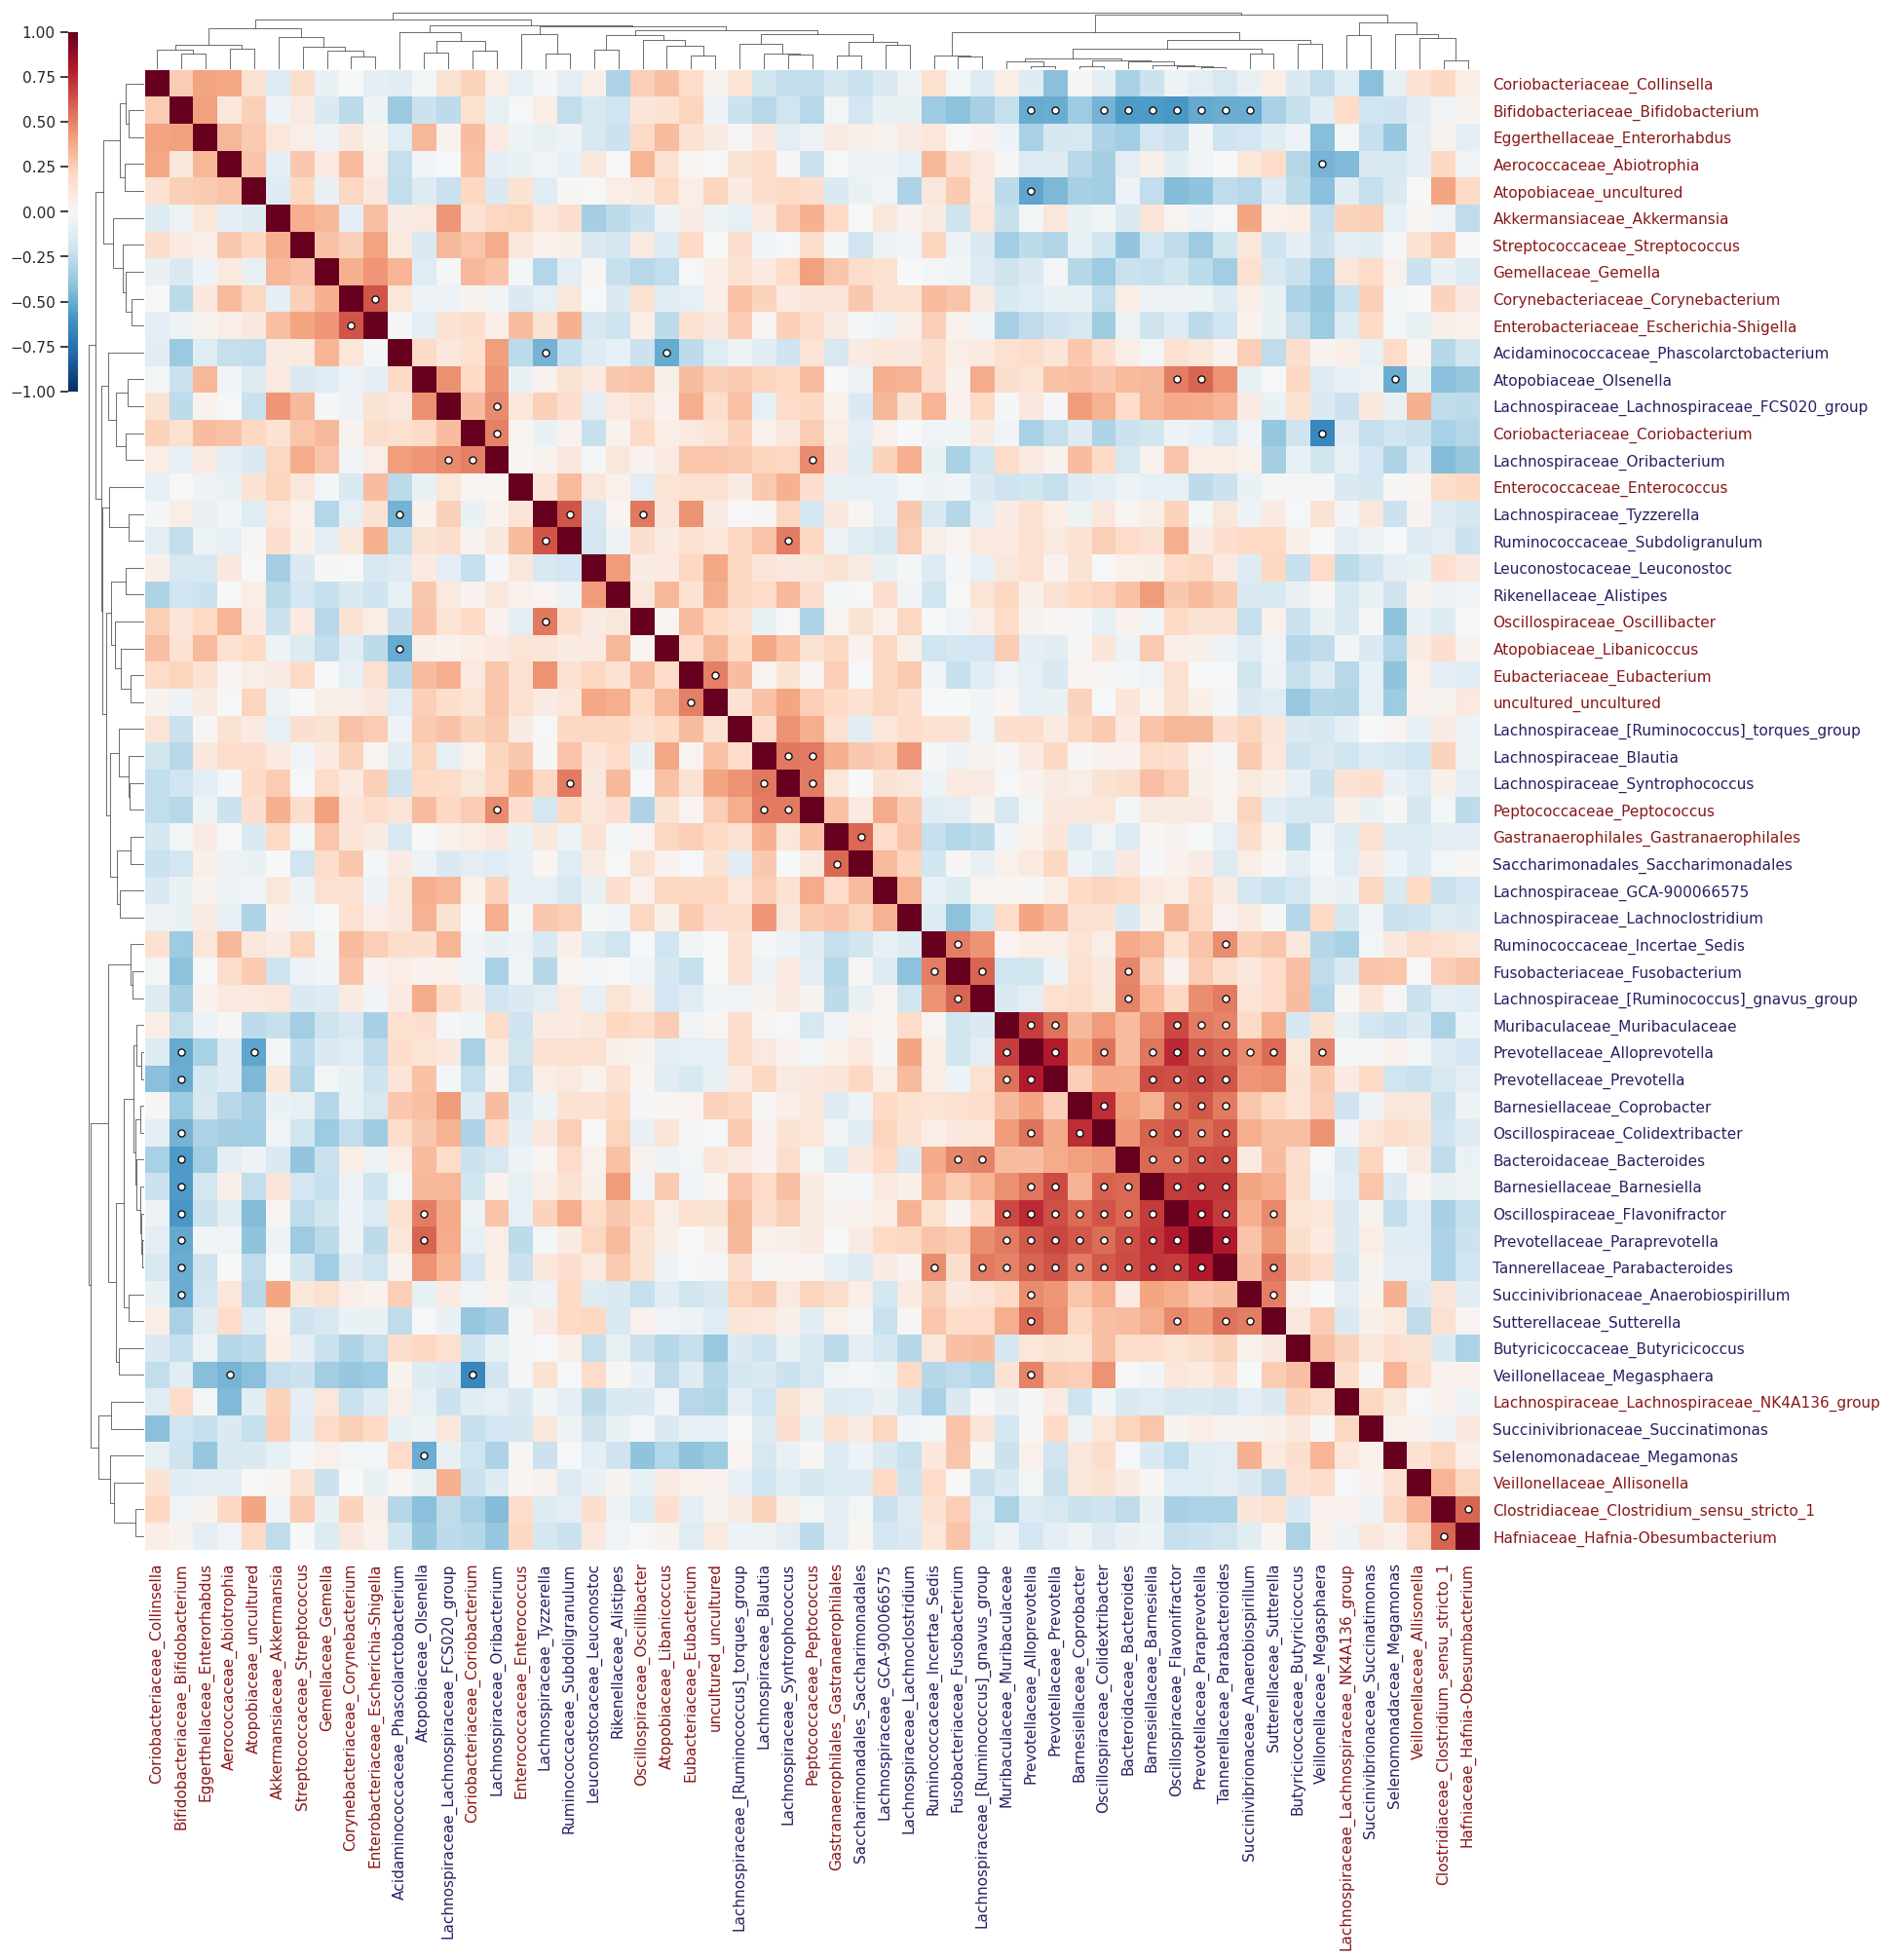

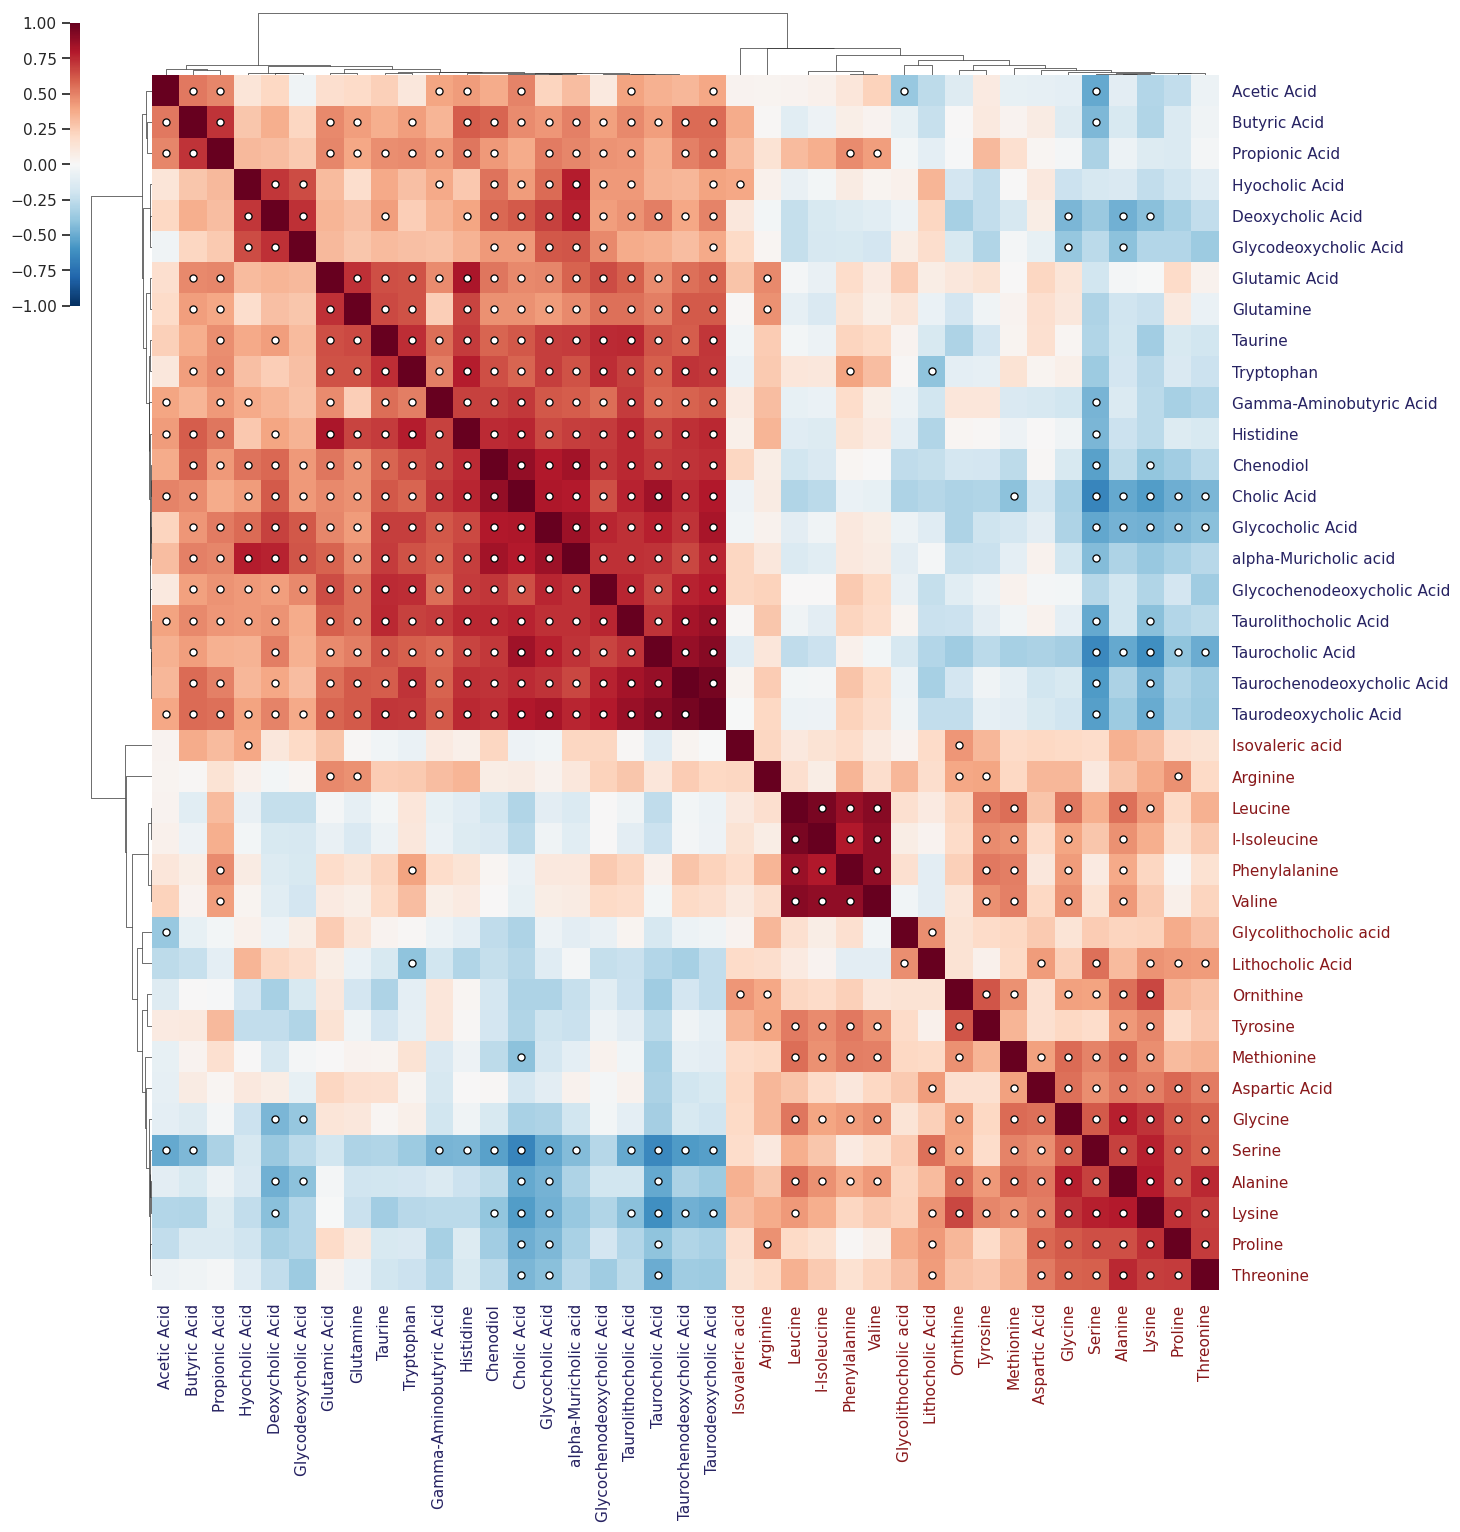

In [31]:
pat = re.compile('^.+\/(.+)-(.+)$')
np.random.seed(777)

for dir in hallaOutput.iterdir():
    with open(nodeDir.joinpath('labels.tsv'), 'w') as f:
        f.write('Feature\tEigenvector\tLabel\n')
        for d in dir.iterdir():
            match = pat.match(str(d))
            # Symmetrical matrices are processed differently than asymmetrical ones
            if match and match.group(1) == match.group(2):
                associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t').pivot(index = 'X_features', columns='Y_features')
    
                # For symmetric matrices, the first eigenvector from the eigendecomposed correlation matrix is used to classify
                # each feature into 'Positive' or 'Negative' correlation type
                X = associations['association'].to_numpy()
                pca = sklearn.decomposition.PCA()
                pca.fit(X)
                pc1 = pca.components_[:1,:]
                cortypes = pd.DataFrame(pc1.T, index=associations['association'].columns, columns=['Eigenvector'])
                cortypes['Label'] = cortypes['Eigenvector'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
                cortypes['Color'] = cortypes['Label'].apply(lambda x: '#89181A' if x == 'Positive' else '#262262')

                if dir.name == 'non_graphical_output':
                    cortypes.to_csv(f, mode='a', sep='\t', index=True, header=False)
                
                # A clustermap is created with features labeled according to their eigenvector
                sim_table = associations['association']
                qvals = associations['q-values']
                fdr_reject_table = (qvals < 0.05).to_numpy()
                vmax, vmin = sim_table.values.max(), sim_table.values.min()
                
                if vmin < 0 and vmax > 0:
                    vmax = max(abs(vmin), vmax)
                    vmin = -vmax
                figsize = (max(5, 0.3*sim_table.shape[1]+2.5), max(5, 0.3*sim_table.shape[0]+4))
                dendrogram_ratio = (0.8/figsize[0], 0.8/figsize[1])
                cbar_pos = (0, 0.8, 0.1/figsize[0], 0.18)
                cbar_kws = { 'label': '', 'ticklocation': 'left' }
                clustermap = sns.clustermap(sim_table, metric='correlation', cmap='RdBu_r', vmin=vmin, vmax=vmax, figsize=figsize, dendrogram_ratio=dendrogram_ratio, 
                                            cbar_pos=cbar_pos, cbar_kws=cbar_kws, zorder=2, xticklabels=sim_table.index, yticklabels=sim_table.columns
                )
                ax = clustermap.ax_heatmap
                ax.set_xlabel('', fontweight='bold')
                ax.set_ylabel('', fontweight='bold')
                ax.tick_params(right=False)
                
                # Features are colored according to their eigenvector (Red if positive, Blue if negative)
                for xtick, ytick in zip(ax.get_xticklabels(), ax.get_yticklabels()):
                    xtick.set_color(cortypes.loc[xtick.get_text(), 'Color'])
                    ytick.set_color(cortypes.loc[ytick.get_text(), 'Color'])
                  
                # Significant correlations are marked with a white dot, as in the HAllA source code
                dot_order_x = np.asarray(clustermap.dendrogram_row.reordered_ind)
                dot_order_y = clustermap.dendrogram_col.reordered_ind
                for i in range(len(sim_table.index)):
                    for j in range(len(sim_table.columns)):
                        if fdr_reject_table[dot_order_x[i],dot_order_y[j]] and i != j:
                            ax.scatter(y = i + .5, x = j + .5, c = 'black', marker = "o", zorder = 3, s = 25)
                            ax.scatter(y = i + .5, x = j + .5, c = 'white', marker = "o", zorder = 3, s = 10)
                            
                if dir.name == 'non_graphical_output':
                    plt.savefig(figureDir.joinpath(d.name + '_fullname_clustergram.pdf'), format='pdf', bbox_inches='tight')
                else:
                    plt.savefig(figureDir.joinpath(d.name + '_clustergram.pdf'), format='pdf', bbox_inches='tight')

<h3>Degree Distribution Calculation & Power-law Fitting</h3>
<p>Cytoscape csv files were exported from Cytoscape into a directory called "cytoscape_network_csvs", which is in analysisDir. The following code can be run after that is done. It calculates the degree distribution and fits a power-law distribution to the data using poweRlaw</p>
<h4>WARNING</h4>
<p>For whatever reason, the code in this section is very unstable. The metabolite-metabolite degree distribution's bootstrap p-value and comparison to other distributions will fluctuate between 2 different values depending on how the model fits the data. Specifically, the bootstrap p-value fluctuates between 0.0486 and 0.1656. Attempts to fix the issue were made, including trying to pass the set.seed function instead of a random seed value to the bootstrap_p function, and changing the package version to an earlier build. The 0.0486 variant is what was reported in the manuscript as that is what was encountered first, and that variant appeared consistently when running and re-running this code to produce all figures in the manuscript.</p>

In [32]:
cytoDir = analysisDir.joinpath('cytoscape_network_csvs')
if not cytoDir.exists():
    cytoDir.mkdir()
cytoPath = cytoDir.as_posix()

In [33]:
%%capture --no-stdout
%%R -i n_cores,figurePath,cytoPath -w 700 -h 500

# Power law article: https://stats.stackexchange.com/questions/108843/how-to-test-whether-a-distribution-follows-a-power-law
library(poweRlaw)
library(ggplot2)
library(igraph)
library(data.table)

csvDir <- cytoPath
# Degree distributions are added to a list
degree_dists <- list()

# List of network csv's generated from Cytoscape
network_files <- c("metab_metab.csv", "microbe_microbe.csv", "microbe_metab.csv")

for (network_file in network_files) {
    # The network file is read and parsed
    network_path <- paste(csvDir, '/', network_file, sep='')
    network <- fread(network_path)
    colnames(network) <- make.names(colnames(network))
    net <- network[,c('shared.name', 'common_name', 'Degree')]
    # The file name is removed from the network file for future purposes
    nfile <- substr(network_file, 1, nchar(network_file)-4)

    ### Degree distribution is calculated for each network in the list ###
    frequencies <- as.data.frame(table(net$Degree))
    colnames(frequencies) <- c("k", "Abs_Freq")
    frequencies$k <- as.numeric(levels(frequencies$k))[frequencies$k]
    n <- max(frequencies$k)
    degree_dists[[nfile]] <- as.data.frame(matrix(0, ncol = 2, nrow = n))
    colnames(degree_dists[[nfile]]) <- colnames(frequencies)

    # The degree distribution list only has non-zero degrees, so missing
    # degrees are filled in here
    # (e.g., if some nodes have degrees of 1 and 3, but not 2, 2 would be added here)
    for (i in 1:n) {
        if (! (i %in% frequencies$k)) {
        degree_dists[[nfile]][i,] <- c(i, 0)
        }
        else {
        degree_dists[[nfile]][i,] <- frequencies[frequencies$k==i,]
        }
    }
    degree_dists[[nfile]]$Rel_Freq <- degree_dists[[nfile]]$Abs_Freq / dim(net)[1]
    # print(degree_dists)
    ### Degree distribution is plotted ###
    df <- degree_dists[[nfile]]
    degplot <- ggplot(df,aes(x=k,y=Abs_Freq)) +
        geom_col(color='black',fill='orange') +
        
        scale_y_continuous(breaks = function(x) unique(floor(pretty(seq(min(x), (max(x) + 1) * 1.1)))),
                           limits = c(0, 15)) +
        scale_x_continuous(breaks = function(x) unique(floor(pretty(seq(min(x), (max(x) + 1) * 1.1)))),
                           limits = function(x) c(0, (max(x)+3))) + 
        xlab("Node Degree") +
        ylab("Node Count")
    ggsave(paste(nfile, '_degree_dist.pdf', sep=''), plot=degplot, device='pdf', path=figurePath, width=5, height=5, units='in')

    ### A power-law distribution is fitted to the degree centrality list ###
    data_pl <- displ$new(net$Degree)
    data_pl$setXmin(estimate_xmin(data_pl))

    # A p-value is calculated to assess the goodness of the fit via bootstrapping
    bs_p <- bootstrap_p(data_pl, seed=777, no_of_sims=5000, threads=n_cores)
    cat(paste('\n##################################\n', paste(nfile, ' power-law bootstrap', sep=''), 
              '\n##################################\n', sep='\n'))
    cat(paste('$p:', bs_p$p, '\n$gof:', bs_p$gof, '\n$sim_time:', bs_p$sim_time, '\n$seed:', bs_p$seed, 
              '\n$package_version:', bs_p$package_version, '\n$distance:', bs_p$distance, '\n', sep='\n'))

    # A log-normal distribution is fitted and subsequenty compared to power-law fit
    data_ln <- dislnorm$new(net$Degree)
    data_ln$setXmin(data_pl$getXmin())
    data_ln$setPars(estimate_pars(data_ln))
    comp_ln <- compare_distributions(data_pl, data_ln)
    cat('########################\n\ncomparing distributions\n\n########################\n')
    cat("----------------------\nlog-normal comparison\n----------------------\n")
    cat(paste('$test_statistic:', comp_ln$test_statistic, '\n$p_one_sided:', comp_ln$p_one_sided,
              '\n$p_two_sided:', comp_ln$p_two_sided, '\n', sep='\n'))

    # An exponential distribution is fitted and subsequenty compared to power-law fit
    data_exp <- disexp$new(net$Degree)
    data_exp$setXmin(data_pl$getXmin())
    data_exp$setPars(estimate_pars(data_exp))
    comp_exp <- compare_distributions(data_pl, data_exp)
    cat("----------------------\nexp comparison\n----------------------\n")
    cat(paste('$test_statistic:', comp_exp$test_statistic, '\n$p_one_sided:', comp_exp$p_one_sided,
              '\n$p_two_sided:', comp_exp$p_two_sided, '\n', sep='\n'))

    # A poisson distribution is fitted and subsequenty compared to power-law fit
    data_pois <- dispois$new(net$Degree)
    data_pois$setXmin(data_pl$getXmin())
    data_pois$setPars(estimate_pars(data_pois))
    comp_pois <- compare_distributions(data_pl, data_pois)
    cat("----------------------\npois comparison\n----------------------\n")
    cat(paste('$test_statistic:', comp_pois$test_statistic, '\n$p_one_sided:', comp_pois$p_one_sided,
              '\n$p_two_sided:', comp_pois$p_two_sided, '\n', sep='\n'))

    ### Plotting of fitted distributions ###
    pdf(paste(figurePath, '/', nfile, '_fitted_distributions.pdf', sep=''),
        width = 7, height = 5, # Width and height in inches
        bg = "white",          # Background color
        colormodel = "cmyk"
    )
    par(mar=c(4.1, 4.1, 4.1, 8.1)) # Add extra space to right of plot area
    plot(data_pl, ylab="CDF", xlab="Node Degree", pch = 21, bg='orange')
    lines(data_pl, col = 1)
    lines(data_ln, col = 2)
    lines(data_exp, col=3)
    lines(data_pois, col = 4)
    legend("topright", # legend starting position
           inset=c(-0.3,0), # Changes the legend position while keeping it outside of the plot itself
           legend=c('power-law', 'log-normal', 'exponential', 'poisson'),
           col=c(1,2,3,4), # Colors in the legend
           title='Distribution Type',
           xpd=TRUE, # xpd changes clipping to legend
           bty="n", # removes border around the legend
           cex=0.85, # changes the legend's size
           lty=1 # Changes the reference lines in the legend (can be dots, lines, both, etc)
    )
    dev.off()

    # Figures are also saved for bootstrap results (p-value figure is manually isolated later)
    pdf(paste(figurePath, '/', nfile, '_bootstrap_results.pdf', sep=''))
    plot(bs_p)
    dev.off()
}

/home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/R: /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../.././libtinfo.so.6: no version information available (required by /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../../libreadline.so.8)
/home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/R: /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../.././libtinfo.so.6: no version information available (required by /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../../libreadline.so.8)
/home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/R: /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../.././libtinfo.so.6: no version information available (required by /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/..


##################################

metab_metab power-law bootstrap

##################################
$p:
0.0486

$gof:
0.156812326960764

$sim_time:
0.0954083953857422

$seed:
777

$package_version:
0.70.6

$distance:
ks

########################

comparing distributions

########################
----------------------
log-normal comparison
----------------------
$test_statistic:
-1.31438154218327

$p_one_sided:
0.905641080616967

$p_two_sided:
0.188717838766067

----------------------
exp comparison
----------------------
$test_statistic:
-2.56412131161116

$p_one_sided:
0.994828130770046

$p_two_sided:
0.0103437384599074

----------------------
pois comparison
----------------------
$test_statistic:
-1.6563972647142

$p_one_sided:
0.951179302666206

$p_two_sided:
0.0976413946675881



/home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/R: /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../.././libtinfo.so.6: no version information available (required by /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../../libreadline.so.8)
/home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/R: /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../.././libtinfo.so.6: no version information available (required by /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../../libreadline.so.8)
/home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/R: /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../.././libtinfo.so.6: no version information available (required by /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/..


##################################

microbe_microbe power-law bootstrap

##################################
$p:
0.1378

$gof:
0.113300036846848

$sim_time:
0.0536099029541016

$seed:
777

$package_version:
0.70.6

$distance:
ks

########################

comparing distributions

########################
----------------------
log-normal comparison
----------------------
$test_statistic:
-1.38639353709692

$p_one_sided:
0.917186615583154

$p_two_sided:
0.165626768833692

----------------------
exp comparison
----------------------
$test_statistic:
-1.24443307745466

$p_one_sided:
0.893329892324806

$p_two_sided:
0.213340215350389

----------------------
pois comparison
----------------------
$test_statistic:
1.49118672515662

$p_one_sided:
0.0679562389651349

$p_two_sided:
0.13591247793027



/home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/R: /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../.././libtinfo.so.6: no version information available (required by /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../../libreadline.so.8)
/home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/R: /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../.././libtinfo.so.6: no version information available (required by /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../../libreadline.so.8)
/home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/R: /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/../../lib/../.././libtinfo.so.6: no version information available (required by /home/claytonlab/jhernandez/.conda/envs/marm-micro-metab-env/lib/R/bin/exec/..


##################################

microbe_metab power-law bootstrap

##################################
$p:
0.5408

$gof:
0.0583183281903178

$sim_time:
0.0442592384338379

$seed:
777

$package_version:
0.70.6

$distance:
ks

########################

comparing distributions

########################
----------------------
log-normal comparison
----------------------
$test_statistic:
-0.447887683462267

$p_one_sided:
0.672882871157588

$p_two_sided:
0.654234257684823

----------------------
exp comparison
----------------------
$test_statistic:
1.01059712048174

$p_one_sided:
0.156104647287584

$p_two_sided:
0.312209294575168

----------------------
pois comparison
----------------------
$test_statistic:
1.3008322856573

$p_one_sided:
0.0966579341124696

$p_two_sided:
0.193315868224939



<h3>Visualization of Relationship Between Taxa Abundance and Beta Diversity Between Samples</h3>
<p>A PCoA of Bray-Curtis dissimilarity is colored by the relative abundance of the top 6 most abundant and 6 most central taxa. </p>

In [34]:
interestGenera = ['Bifidobacterium', 'Bacteroides', 'Megasphaera', 'Megamonas', 'Phascolarctobacterium', 'Prevotella', 
                    'Clostridium_sensu_stricto_1', 'Alloprevotella', 'Parabacteroides', 'Flavonifractor', 'Hafnia-Obesumbacterium', 'Paraprevotella']
genCols = [i for i in range(0, relativeGenera.columns.shape[0]) if relativeGenera.columns[i].split(';')[-1][3:] in interestGenera]
interestGen = relativeGenera.iloc[:, genCols]
interestGen.columns = interestGen.columns.str.split(';').str[-1].str[3:]
interestGenGTZero = (interestGen > 0).replace({True: 'Y', False: 'N'})
interestGenGTZero.columns = interestGenGTZero.columns + '_nonzero'
newMeta = pd.concat([sampleMeta, interestGen, interestGenGTZero], axis=1)

R[write to console]: Loading required package: viridisLite



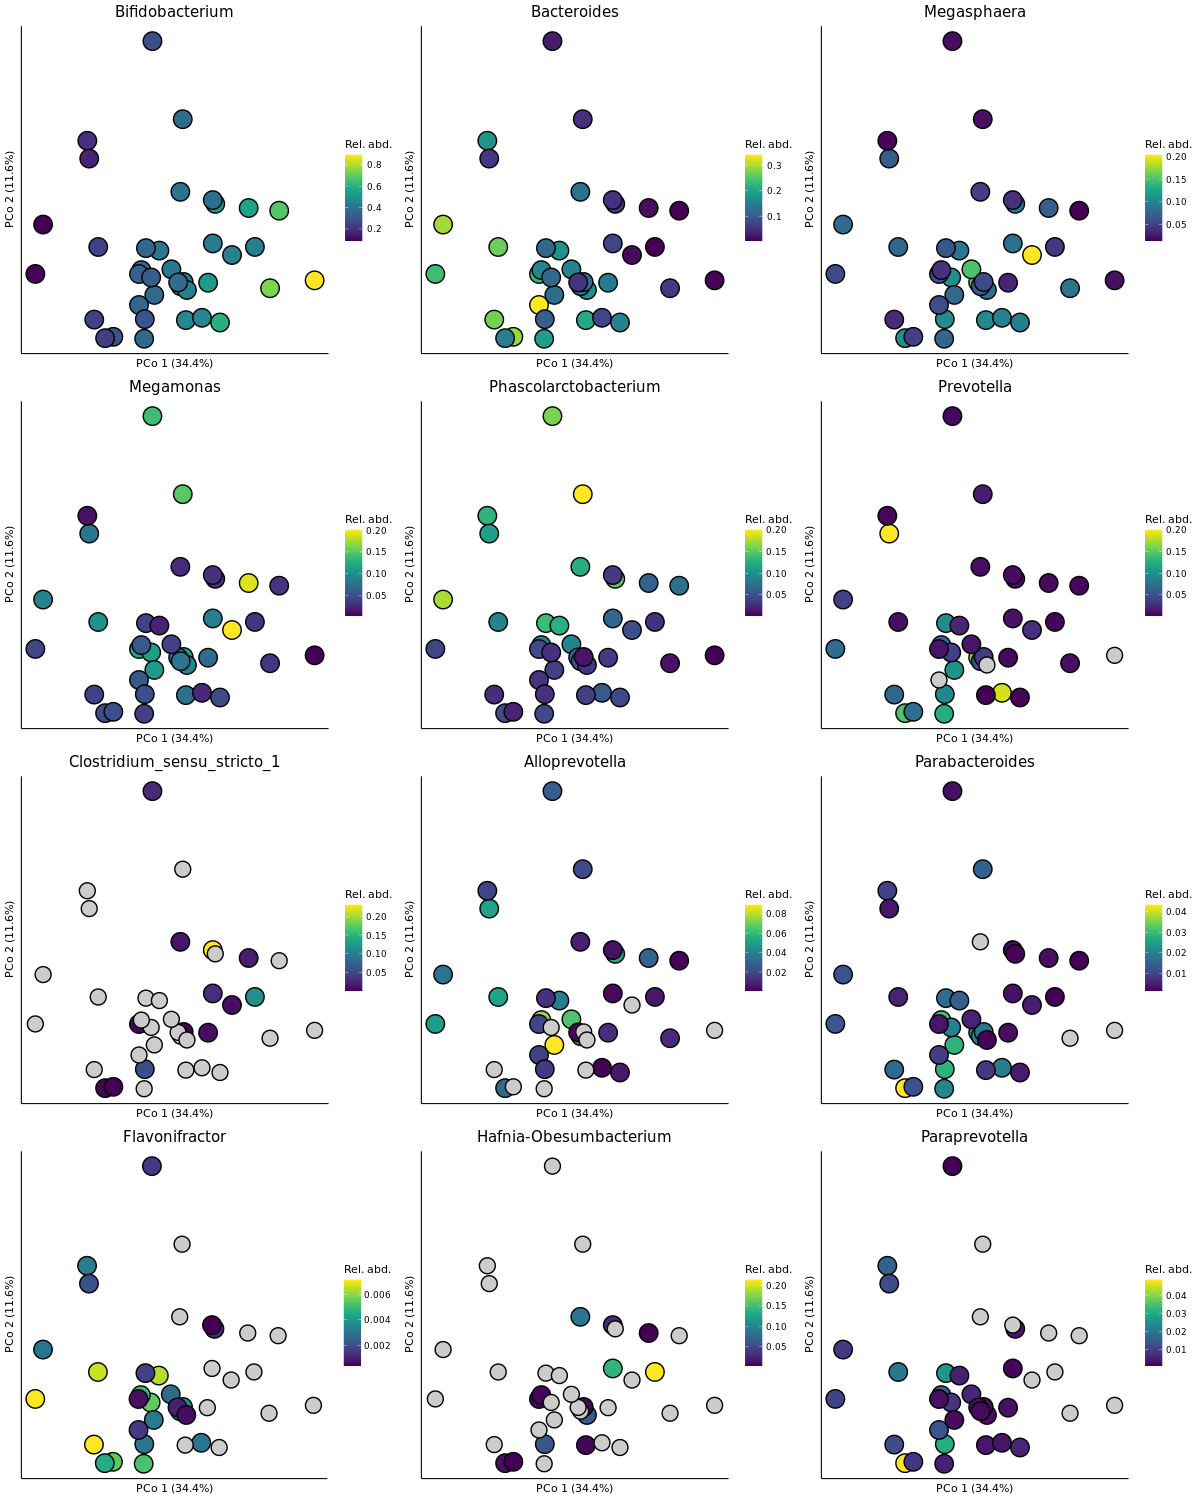

In [35]:
%%R -i figurePath,newMeta,metabScaled,interestGenera -w 1200 -h 1500
source("rFunctions.R")
### Ordination ###
newMeta$Relative_Day <- as.integer(newMeta$Relative_Day)

# Dataframes are concatenated with appropriate metadata
relGeneraDat <- convertDF(relativeGenera, newMeta)
targMetabDat <- convertDF(metabScaled, newMeta)
targMetabDat$metaF <- targetedFeatureMeta

# Microbiome data is row-sum normalized
relGeneraDat.nrm <- relGeneraDat
genSums <- rowSums(relGeneraDat.nrm$x)
relGeneraDat.nrm$x <- relGeneraDat.nrm$x / genSums

# Metabolomics data is normalized within method
targMetabDat.nrm <- targMetabDat
imputed <- apply(targMetabDat$x, 2, median)
nfixed <- 0

for (i in seq_along(rownames(targMetabDat.nrm$x))) {
    prf <- targMetabDat.nrm$x[i,]
    nprf <- prf / ave(as.numeric(prf), list(as.character(targMetabDat$metaF["Method",])), FUN=sum)
    outlier <- nprf > 0.5
    
    # Outliers are replaced with the median and normalized again
    while (any(outlier)) {
        nfixed <- nfixed + sum(outlier)
        prf[outlier] <- imputed[outlier]
        nprf <- prf / ave(as.numeric(prf), list(as.character(targMetabDat$metaF["Method",])), FUN=sum)
        outlier <- nprf > 0.5
    }
    targMetabDat.nrm$x[i,] <- nprf
}

interestGenera[interestGenera == 'Hafnia-Obesumbacterium'] <- "Hafnia.Obesumbacterium"
relGeneraDat.nrm$metaS[, interestGenera] <- as.data.frame(apply(relGeneraDat.nrm$metaS[, interestGenera], 2, as.numeric))
targMetabDat.nrm$metaS[, interestGenera] <- as.data.frame(apply(targMetabDat.nrm$metaS[, interestGenera], 2, as.numeric))

generaPCoA <- PCoA(relGeneraDat.nrm)
metabPCoA <- PCoA(targMetabDat.nrm)

# Size parameter used for PCoA dot size
abs_size=8

bactPlots <- list()
bactPlots <- lapply(1:length(interestGenera), function(i) {

    # 0 values are replaced with NA for ease of differentiating them during plotting
    relGeneraDat.nrm$metaS[interestGenera[i]][relGeneraDat.nrm$metaS[interestGenera[i]] == 0] <- NA
    
    bactPlot <- ordplot(relGeneraDat.nrm, generaPCoA, size_abs=abs_size, outline_size=1, colour=interestGenera[i],
                        colour_title="Rel. abd.", size=paste(interestGenera[i], '_nonzero', sep=''),
                        size_override=list("Y"=abs_size, "N"=abs_size*0.85),
                        sortby=interestGenera[i], decreasing=T) +
                        guides(size="none") +
                        ggtitle(gsub('\\.', '-', interestGenera[i])) + theme(plot.title=element_text(size=15, hjust=0.5))
    bactPlots[[i]] <- bactPlot
})

generaPlot <- ggarrange(plotlist=bactPlots, ncol=3, nrow=4)
ggsave('generaAbundPCoA.pdf', plot=generaPlot, device='pdf', path=figurePath, width=12, height=15, units='in')

plot(generaPlot)

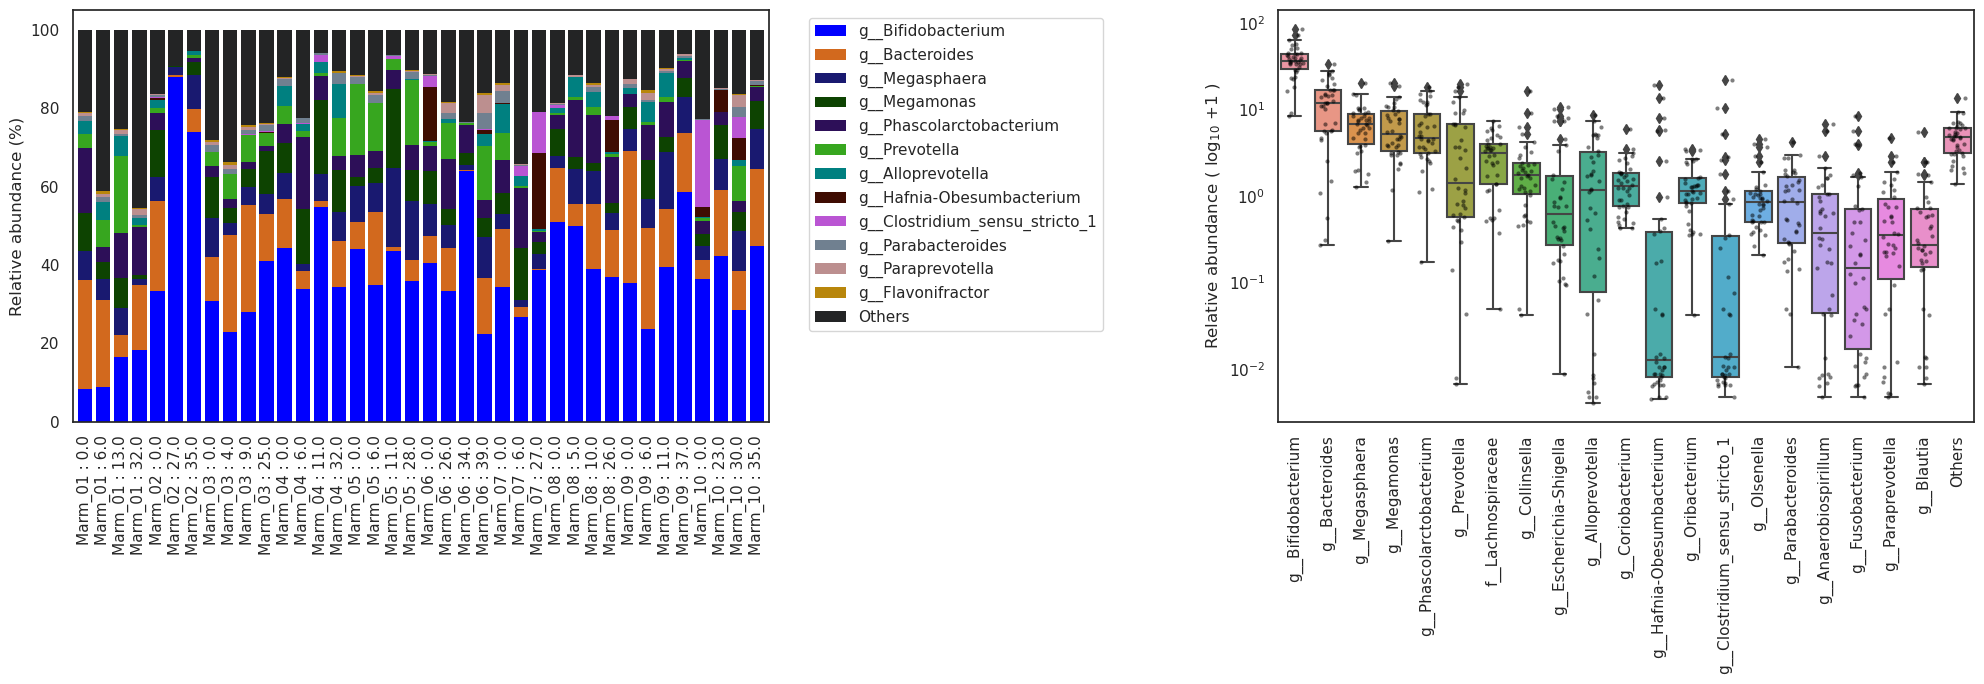

In [36]:
### Taxonomy Visualization ###
# This list contains the 6 most mean abundant taxa and the 6 taxa with the highest KCS
taxa_list = ['d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium',
             'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides',
             'd__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Megasphaera',
             'd__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Selenomonadaceae;g__Megamonas',
             'd__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium',
             'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella',
             'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella',
             'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Hafniaceae;g__Hafnia-Obesumbacterium',
             'd__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium_sensu_stricto_1',
             'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides',
             'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Paraprevotella',
             'd__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__Flavonifractor']

color_list = ['blue', 'chocolate', 'midnightblue', '#0D4301', '#2D0F58', '#37A61F', 'teal', '#3F0C02',
               'mediumorchid', 'slategrey', 'rosybrown', 'darkgoldenrod', '#232425']

taxa_level = 6
filtered_samps = filtered_table.view(pd.DataFrame).index
samp_list = sampleMeta.loc[(sampleMeta.index.isin(filtered_samps))].index.astype(int).to_list()

## Taxonomy by sample name ##
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20, 7), gridspec_kw={'width_ratios': [2, 0.5, 2]})
dokdo.taxa_abundance_bar_plot(
    taxa_bar_plots_viz,
    ax=ax1,
    level=taxa_level,
    sample_names=samp_list,
    label_columns=['Anon_Individual', 'Relative_Day'],
    sort_by_mean3=True,
    taxa_names=taxa_list,
    colors=color_list,
    cmap_name='tab20',
    legend=False
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plots_viz,
    ax=ax2,
    level=taxa_level,
    sample_names=samp_list,
    label_columns=['Anon_Individual', 'Relative_Day'],
    sort_by_mean3=True,
    taxa_names=taxa_list,
    cmap_name='tab20',
    colors=color_list,
    legend_short=True
)

handles, labels = ax2.get_legend_handles_labels()

ax2.clear()
ax2.legend(handles, labels)
ax2.axis('off')

dokdo.taxa_abundance_box_plot(
    taxa_bar_plots_viz,
    level=taxa_level,
    sample_names=samp_list,
    count=21,
    pretty_taxa=True,
    add_datapoints=True,
    pseudocount=True,
    alpha=0.5,
    jitter=0.25,
    size=3,
    ax=ax3
)

ax3.set_ylabel('Relative abundance ( log$_{10}$ +1 )')
ax3.set_yscale('log', base=10)
plt.tight_layout()
plt.savefig(figureDir.joinpath('relative_abundance.pdf'), dpi=300, format='pdf')